In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datetime import datetime

from tqdm import tqdm
import json

from sklearn.preprocessing import normalize

In [2]:
from code import model
from code.data import Dataset
from code import epoch
from code import evaluation

In [3]:
root = os.getcwd()
batch = 8
forecast = 30
samples = 5
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# date_time = datetime.strftime(datetime.now(), "%Y-%m-%d_%H-%M")
date_time = "2021-04-09_14-37"

# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
        def __init__(self, classes, input_size=4, in_features=32):
                super(Decoder, self).__init__()

#                 self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
                self.linear1 = nn.Linear(in_features=400, out_features=in_features, bias=True)
                self.linear2 = nn.Linear(in_features=in_features, out_features=classes, bias=True)
                self.flatten = nn.Flatten(start_dim=1)
                self.relu = nn.ReLU(inplace=True)

        def forward(self, x):
#                 print(x.size())
                x = torch.squeeze(x, 1)    # batch, 100, 4

#                 output, (h, c) = self.rnn(x)
                # print(output.size())
                # print(h.size())
                # h = num_layers * num_directions, batch, hidden_size
#                 x = torch.transpose(h, 0, 1)
                # h = batch, num_layers * num_directions, hidden_size
#                 x, _ = torch.max(x, dim=1)
                
                x = self.flatten(x)
                x = self.linear1(x)
                x = self.relu(x)
                x = self.linear2(x)
#                 print(x.shape)
#                 print(x.size())
                return x

In [5]:
def load_checkpoint(filepath, device):

    encoder = model.Extractor(in_channels=1, out_channels=1, maxpool=False)
    decoder = Decoder(classes=forecast) # forcast 30 days

    predictor = model.Model(encoder=encoder, decoder=decoder).to(device)
    
        
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        predictor.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])
        
        print("Find pretrain.")

    else:
        optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-4)
        
        print("New model and optimizer")
        
    return predictor, optimizer

In [6]:
dataset = Dataset(path=os.path.join(root, "training.csv"))

In [7]:
predictor, optimizer = load_checkpoint(
                        filepath=os.path.join(root, "results", date_time, "{}.pth".format(date_time)),
                        device=device)

Find pretrain.


In [8]:
trainloader = DataLoader(dataset, batch_size=batch, shuffle=False, num_workers=2)

In [8]:
train_info = {
       "kendal": []
}

kendal_min = 1
for e in range(5000):
    
    train_loss = epoch.train_epoch(predictor, optimizer, trainloader, device)
    pr, gt = epoch.test_epoch(predictor, dataset, device)
    
    kendal = evaluation.normalised_kendall_tau_distance(gt, pr)
    train_info["kendal"].append(kendal)
    
    print("Epoch: {}, loss = {:.5f}, kendal = {:.5f}".format(e+1, train_loss, kendal))
    
    if kendal < kendal_min:
        checkpoint = {
            'model_stat': predictor.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }

        torch.save(checkpoint, os.path.join(root, "results", date_time, "{}.pth".format(date_time)))
        kendal_min = kendal
    with open(os.path.join(root, "results", date_time, "{}.pth".format(date_time)), 'w') as f:
        json.dump(train_info, f)

145it [00:03, 39.31it/s]
1158it [00:08, 128.99it/s]

Epoch: 1, loss = 0.70129, kendal = 0.49838



145it [00:03, 44.13it/s]
1158it [00:08, 136.76it/s]

Epoch: 2, loss = 0.69576, kendal = 0.41469



145it [00:02, 57.60it/s]
1158it [00:07, 149.06it/s]

Epoch: 3, loss = 0.69369, kendal = 0.27874



145it [00:03, 43.93it/s]
1158it [00:09, 121.76it/s]


Epoch: 4, loss = 0.69258, kendal = 0.35269


145it [00:03, 42.70it/s]
1158it [00:08, 129.48it/s]


Epoch: 5, loss = 0.69115, kendal = 0.36803


145it [00:02, 61.42it/s]
1158it [00:06, 169.58it/s]

Epoch: 6, loss = 0.68949, kendal = 0.38728



145it [00:02, 58.62it/s]
1158it [00:09, 126.02it/s]

Epoch: 7, loss = 0.68790, kendal = 0.34222



145it [00:03, 43.20it/s]
1158it [00:09, 119.96it/s]

Epoch: 8, loss = 0.68648, kendal = 0.55597



145it [00:03, 43.54it/s]
1158it [00:09, 116.74it/s]

Epoch: 9, loss = 0.68387, kendal = 0.38177



145it [00:06, 23.58it/s]
1158it [00:20, 55.21it/s]

Epoch: 10, loss = 0.68191, kendal = 0.57468



145it [00:06, 21.22it/s]
1158it [00:23, 50.32it/s]


Epoch: 11, loss = 0.67994, kendal = 0.62753


145it [00:06, 21.07it/s]
1158it [00:18, 63.65it/s]

Epoch: 12, loss = 0.67801, kendal = 0.59388



145it [00:11, 12.47it/s]
1158it [00:35, 32.78it/s]

Epoch: 13, loss = 0.67633, kendal = 0.51121



145it [00:10, 14.07it/s]
1158it [00:33, 34.68it/s]

Epoch: 14, loss = 0.67429, kendal = 0.52805



145it [00:10, 13.27it/s]
1158it [00:34, 33.16it/s]


Epoch: 15, loss = 0.67292, kendal = 0.60990


145it [00:11, 12.99it/s]
1158it [00:33, 34.63it/s]

Epoch: 16, loss = 0.67045, kendal = 0.62875



145it [00:11, 13.06it/s]
1158it [00:33, 34.94it/s]

Epoch: 17, loss = 0.66899, kendal = 0.60526



145it [00:10, 14.04it/s]
1158it [00:36, 31.86it/s]

Epoch: 18, loss = 0.66669, kendal = 0.68974



145it [00:10, 13.66it/s]
1158it [00:32, 35.35it/s]

Epoch: 19, loss = 0.66503, kendal = 0.66930



145it [00:10, 14.07it/s]
1158it [00:32, 35.88it/s]


Epoch: 20, loss = 0.66370, kendal = 0.70512


145it [00:10, 13.30it/s]
1158it [00:34, 33.23it/s]

Epoch: 21, loss = 0.66224, kendal = 0.69569



145it [00:11, 12.30it/s]
1158it [00:32, 35.81it/s]

Epoch: 22, loss = 0.66044, kendal = 0.72902



145it [00:10, 13.87it/s]
1158it [00:34, 33.85it/s]


Epoch: 23, loss = 0.65928, kendal = 0.73821


145it [00:12, 11.94it/s]
1158it [00:34, 33.23it/s]


Epoch: 24, loss = 0.65782, kendal = 0.74879


145it [00:10, 14.05it/s]
1158it [00:32, 35.13it/s]

Epoch: 25, loss = 0.65573, kendal = 0.75519



145it [00:10, 14.12it/s]
1158it [00:37, 31.19it/s]

Epoch: 26, loss = 0.65640, kendal = 0.75932



145it [00:10, 13.83it/s]
1158it [00:32, 35.75it/s]

Epoch: 27, loss = 0.65352, kendal = 0.75866



145it [00:10, 13.91it/s]
1158it [00:33, 34.59it/s]


Epoch: 28, loss = 0.65288, kendal = 0.75202


145it [00:12, 11.44it/s]
1158it [00:35, 33.06it/s]


Epoch: 29, loss = 0.65205, kendal = 0.76300


145it [00:10, 14.08it/s]
1158it [00:32, 35.42it/s]


Epoch: 30, loss = 0.65109, kendal = 0.75350


145it [00:11, 13.10it/s]
1158it [00:34, 33.50it/s]

Epoch: 31, loss = 0.64942, kendal = 0.75629



145it [00:11, 12.86it/s]
1158it [00:32, 35.57it/s]


Epoch: 32, loss = 0.64884, kendal = 0.75055


145it [00:10, 14.04it/s]
1158it [00:32, 35.36it/s]


Epoch: 33, loss = 0.64688, kendal = 0.75615


145it [00:11, 13.13it/s]
1158it [00:36, 32.15it/s]

Epoch: 34, loss = 0.64693, kendal = 0.75180



145it [00:10, 13.47it/s]
1158it [00:32, 35.51it/s]

Epoch: 35, loss = 0.64545, kendal = 0.75874



145it [00:10, 13.36it/s]
1158it [00:32, 35.47it/s]


Epoch: 36, loss = 0.64400, kendal = 0.74739


145it [00:10, 13.37it/s]
1158it [00:35, 32.26it/s]


Epoch: 37, loss = 0.64296, kendal = 0.75397


145it [00:11, 13.17it/s]
1158it [00:31, 36.22it/s]


Epoch: 38, loss = 0.64328, kendal = 0.75190


145it [00:10, 14.13it/s]
1158it [00:33, 34.17it/s]


Epoch: 39, loss = 0.64113, kendal = 0.74515


145it [00:11, 12.74it/s]
1158it [00:32, 35.48it/s]

Epoch: 40, loss = 0.64118, kendal = 0.74965



145it [00:11, 12.99it/s]
1158it [00:32, 36.12it/s]

Epoch: 41, loss = 0.63913, kendal = 0.74656



145it [00:10, 14.08it/s]
1158it [00:34, 33.49it/s]

Epoch: 42, loss = 0.63929, kendal = 0.74163



145it [00:12, 11.59it/s]
1158it [00:32, 35.37it/s]

Epoch: 43, loss = 0.63761, kendal = 0.75226



145it [00:10, 14.05it/s]
1158it [00:31, 36.52it/s]

Epoch: 44, loss = 0.63754, kendal = 0.74392



145it [00:10, 14.19it/s]
1158it [00:36, 31.39it/s]


Epoch: 45, loss = 0.63663, kendal = 0.75313


145it [00:10, 14.06it/s]
1158it [00:31, 36.20it/s]

Epoch: 46, loss = 0.63619, kendal = 0.75081



145it [00:10, 13.63it/s]
1158it [00:33, 34.95it/s]


Epoch: 47, loss = 0.63502, kendal = 0.75183


145it [00:12, 11.59it/s]
1158it [00:34, 33.48it/s]

Epoch: 48, loss = 0.63375, kendal = 0.74328



145it [00:10, 14.05it/s]
1158it [00:32, 35.29it/s]


Epoch: 49, loss = 0.63219, kendal = 0.74242


145it [00:10, 13.35it/s]
1158it [00:34, 33.90it/s]

Epoch: 50, loss = 0.63198, kendal = 0.74749



145it [00:11, 12.48it/s]
1158it [00:32, 35.11it/s]


Epoch: 51, loss = 0.63102, kendal = 0.74332


145it [00:10, 14.13it/s]
1158it [00:32, 35.36it/s]

Epoch: 52, loss = 0.62995, kendal = 0.75136



145it [00:11, 12.95it/s]
1158it [00:36, 31.85it/s]

Epoch: 53, loss = 0.62888, kendal = 0.74086



145it [00:10, 13.80it/s]
1158it [00:33, 35.06it/s]

Epoch: 54, loss = 0.62884, kendal = 0.74755



145it [00:11, 13.02it/s]
1158it [00:33, 34.75it/s]

Epoch: 55, loss = 0.62780, kendal = 0.74513



145it [00:11, 12.50it/s]
1158it [00:35, 32.98it/s]


Epoch: 56, loss = 0.62679, kendal = 0.75602


145it [00:11, 13.09it/s]
1158it [00:32, 35.85it/s]

Epoch: 57, loss = 0.62603, kendal = 0.74282



145it [00:10, 14.16it/s]
1158it [00:34, 33.33it/s]

Epoch: 58, loss = 0.62370, kendal = 0.75279



145it [00:11, 12.49it/s]
1158it [00:32, 35.51it/s]

Epoch: 59, loss = 0.62346, kendal = 0.74629



145it [00:10, 13.63it/s]
1158it [00:32, 35.28it/s]

Epoch: 60, loss = 0.62304, kendal = 0.74857



145it [00:10, 13.99it/s]
1158it [00:36, 32.09it/s]

Epoch: 61, loss = 0.62101, kendal = 0.74815



145it [00:11, 12.71it/s]
1158it [00:33, 34.93it/s]


Epoch: 62, loss = 0.62187, kendal = 0.74340


145it [00:10, 14.05it/s]
1158it [00:33, 34.66it/s]

Epoch: 63, loss = 0.62069, kendal = 0.74722



145it [00:11, 13.00it/s]
1158it [00:36, 31.97it/s]


Epoch: 64, loss = 0.61970, kendal = 0.74642


145it [00:10, 14.05it/s]
1158it [00:32, 35.42it/s]


Epoch: 65, loss = 0.61968, kendal = 0.74578


145it [00:10, 13.87it/s]
1158it [00:34, 33.42it/s]

Epoch: 66, loss = 0.61677, kendal = 0.74828



145it [00:12, 12.04it/s]
1158it [00:33, 34.29it/s]

Epoch: 67, loss = 0.61771, kendal = 0.74972



145it [00:10, 14.06it/s]
1158it [00:33, 34.31it/s]

Epoch: 68, loss = 0.61709, kendal = 0.74287



145it [00:11, 12.62it/s]
1158it [00:36, 31.38it/s]

Epoch: 69, loss = 0.61494, kendal = 0.74432



145it [00:10, 14.17it/s]
1158it [00:32, 35.41it/s]

Epoch: 70, loss = 0.61483, kendal = 0.75661



145it [00:10, 14.10it/s]
1158it [00:33, 34.60it/s]

Epoch: 71, loss = 0.61365, kendal = 0.75599



145it [00:11, 12.74it/s]
1158it [00:35, 32.77it/s]

Epoch: 72, loss = 0.61453, kendal = 0.74895



145it [00:10, 13.75it/s]
1158it [00:32, 35.46it/s]

Epoch: 73, loss = 0.61304, kendal = 0.74642



145it [00:11, 13.09it/s]
1158it [00:34, 33.96it/s]

Epoch: 74, loss = 0.61200, kendal = 0.75506



145it [00:11, 12.77it/s]
1158it [00:33, 34.76it/s]


Epoch: 75, loss = 0.61121, kendal = 0.74590


145it [00:11, 12.93it/s]
1158it [00:32, 36.10it/s]


Epoch: 76, loss = 0.60947, kendal = 0.74233


145it [00:10, 14.13it/s]
1158it [00:35, 32.32it/s]

Epoch: 77, loss = 0.60796, kendal = 0.75071



145it [00:10, 13.64it/s]
1158it [00:33, 34.60it/s]

Epoch: 78, loss = 0.60621, kendal = 0.74518



145it [00:10, 14.07it/s]
1158it [00:32, 35.39it/s]

Epoch: 79, loss = 0.60704, kendal = 0.74211



145it [00:10, 13.26it/s]
1158it [00:35, 32.99it/s]

Epoch: 80, loss = 0.60711, kendal = 0.74792



145it [00:10, 13.21it/s]
1158it [00:32, 36.00it/s]

Epoch: 81, loss = 0.60569, kendal = 0.74508



145it [00:10, 13.99it/s]
1158it [00:33, 35.07it/s]

Epoch: 82, loss = 0.60554, kendal = 0.74949



145it [00:11, 12.16it/s]
1158it [00:34, 33.72it/s]

Epoch: 83, loss = 0.60426, kendal = 0.75155



145it [00:10, 14.07it/s]
1158it [00:33, 35.07it/s]

Epoch: 84, loss = 0.60294, kendal = 0.75067



145it [00:10, 14.13it/s]
1158it [00:36, 31.97it/s]


Epoch: 85, loss = 0.60174, kendal = 0.74485


145it [00:11, 13.16it/s]
1158it [00:32, 35.47it/s]

Epoch: 86, loss = 0.60270, kendal = 0.74930



145it [00:10, 13.83it/s]
1158it [00:33, 35.00it/s]

Epoch: 87, loss = 0.60234, kendal = 0.75045



145it [00:11, 12.44it/s]
1158it [00:36, 31.79it/s]

Epoch: 88, loss = 0.60018, kendal = 0.75397



145it [00:10, 14.04it/s]
1158it [00:32, 35.33it/s]

Epoch: 89, loss = 0.59887, kendal = 0.74734



145it [00:10, 13.84it/s]
1158it [00:32, 35.17it/s]

Epoch: 90, loss = 0.59939, kendal = 0.75025



145it [00:11, 12.50it/s]
1158it [00:34, 33.91it/s]


Epoch: 91, loss = 0.59790, kendal = 0.75068


145it [00:10, 13.87it/s]
1158it [00:32, 35.81it/s]

Epoch: 92, loss = 0.59730, kendal = 0.74726



145it [00:11, 12.54it/s]
1158it [00:35, 32.77it/s]

Epoch: 93, loss = 0.59767, kendal = 0.75400



145it [00:11, 12.83it/s]
1158it [00:32, 35.80it/s]


Epoch: 94, loss = 0.59485, kendal = 0.75150


145it [00:10, 14.27it/s]
1158it [00:32, 36.07it/s]

Epoch: 95, loss = 0.59486, kendal = 0.75053



145it [00:10, 14.03it/s]
1158it [00:37, 31.04it/s]


Epoch: 96, loss = 0.59445, kendal = 0.75309


145it [00:10, 14.13it/s]
1158it [00:34, 34.05it/s]


Epoch: 97, loss = 0.59401, kendal = 0.75134


145it [00:10, 14.02it/s]
1158it [00:33, 34.67it/s]

Epoch: 98, loss = 0.59234, kendal = 0.75764



145it [00:11, 12.62it/s]
1158it [00:33, 34.37it/s]

Epoch: 99, loss = 0.59155, kendal = 0.75436



145it [00:11, 12.90it/s]
1158it [00:33, 34.78it/s]


Epoch: 100, loss = 0.59110, kendal = 0.74879


145it [00:10, 14.04it/s]
1158it [00:35, 32.64it/s]

Epoch: 101, loss = 0.58933, kendal = 0.75971



145it [00:12, 12.00it/s]
1158it [00:33, 34.31it/s]

Epoch: 102, loss = 0.59099, kendal = 0.75109



145it [00:10, 14.08it/s]
1158it [00:33, 34.96it/s]


Epoch: 103, loss = 0.58771, kendal = 0.75767


145it [00:10, 13.96it/s]
1158it [00:37, 31.09it/s]

Epoch: 104, loss = 0.58812, kendal = 0.75716



145it [00:10, 14.06it/s]
1158it [00:32, 35.89it/s]

Epoch: 105, loss = 0.58678, kendal = 0.75856



145it [00:10, 13.67it/s]
1158it [00:33, 34.41it/s]

Epoch: 106, loss = 0.58615, kendal = 0.75600



145it [00:12, 11.72it/s]
1158it [00:34, 33.48it/s]

Epoch: 107, loss = 0.58370, kendal = 0.75770



145it [00:10, 14.09it/s]
1158it [00:32, 35.11it/s]

Epoch: 108, loss = 0.58537, kendal = 0.74084



145it [00:10, 13.29it/s]
1158it [00:35, 32.86it/s]

Epoch: 109, loss = 0.58314, kendal = 0.75059



145it [00:11, 13.13it/s]
1158it [00:32, 36.10it/s]

Epoch: 110, loss = 0.58285, kendal = 0.75237



145it [00:10, 14.01it/s]
1158it [00:32, 35.87it/s]

Epoch: 111, loss = 0.58283, kendal = 0.75732



145it [00:11, 12.92it/s]
1158it [00:36, 31.71it/s]

Epoch: 112, loss = 0.58215, kendal = 0.75546



145it [00:10, 13.85it/s]
1158it [00:32, 35.64it/s]

Epoch: 113, loss = 0.57960, kendal = 0.75762



145it [00:10, 13.18it/s]
1158it [00:33, 34.63it/s]

Epoch: 114, loss = 0.57961, kendal = 0.74836



145it [00:11, 12.66it/s]
1158it [00:34, 33.95it/s]

Epoch: 115, loss = 0.57961, kendal = 0.75325



145it [00:10, 13.51it/s]
1158it [00:31, 36.74it/s]

Epoch: 116, loss = 0.57803, kendal = 0.75447



145it [00:10, 14.04it/s]
1158it [00:34, 33.89it/s]

Epoch: 117, loss = 0.57816, kendal = 0.74992



145it [00:11, 12.60it/s]
1158it [00:32, 35.67it/s]

Epoch: 118, loss = 0.57494, kendal = 0.75872



145it [00:10, 13.60it/s]
1158it [00:32, 35.38it/s]

Epoch: 119, loss = 0.57618, kendal = 0.75738



145it [00:10, 14.12it/s]
1158it [00:35, 32.19it/s]

Epoch: 120, loss = 0.57539, kendal = 0.75389



145it [00:11, 12.23it/s]
1158it [00:32, 35.54it/s]

Epoch: 121, loss = 0.57486, kendal = 0.75174



145it [00:10, 14.04it/s]
1158it [00:32, 35.98it/s]

Epoch: 122, loss = 0.57367, kendal = 0.75588



145it [00:10, 13.50it/s]
1158it [00:36, 32.05it/s]

Epoch: 123, loss = 0.57351, kendal = 0.74888



145it [00:10, 13.89it/s]
1158it [00:32, 35.56it/s]

Epoch: 124, loss = 0.57147, kendal = 0.75661



145it [00:10, 13.74it/s]
1158it [00:33, 34.44it/s]


Epoch: 125, loss = 0.57159, kendal = 0.74402


145it [00:12, 11.74it/s]
1158it [00:33, 34.22it/s]

Epoch: 126, loss = 0.57064, kendal = 0.75259



145it [00:10, 14.05it/s]
1158it [00:32, 36.00it/s]

Epoch: 127, loss = 0.56988, kendal = 0.75263



145it [00:10, 13.73it/s]
1158it [00:36, 31.75it/s]


Epoch: 128, loss = 0.56862, kendal = 0.74404


145it [00:10, 13.67it/s]
1158it [00:32, 35.31it/s]


Epoch: 129, loss = 0.56831, kendal = 0.75030


145it [00:10, 14.06it/s]
1158it [00:31, 36.36it/s]

Epoch: 130, loss = 0.56650, kendal = 0.75006



145it [00:11, 12.82it/s]
1158it [00:36, 31.92it/s]

Epoch: 131, loss = 0.56745, kendal = 0.74961



145it [00:10, 14.03it/s]
1158it [00:32, 35.99it/s]

Epoch: 132, loss = 0.56538, kendal = 0.74730



145it [00:11, 13.16it/s]
1158it [00:32, 35.58it/s]

Epoch: 133, loss = 0.56385, kendal = 0.74704



145it [00:11, 12.65it/s]
1158it [00:34, 33.76it/s]

Epoch: 134, loss = 0.56247, kendal = 0.74423



145it [00:10, 14.09it/s]
1158it [00:31, 36.67it/s]

Epoch: 135, loss = 0.56338, kendal = 0.75486



145it [00:10, 14.09it/s]
1158it [00:34, 33.12it/s]

Epoch: 136, loss = 0.56317, kendal = 0.74607



145it [00:11, 12.52it/s]
1158it [00:32, 36.16it/s]

Epoch: 137, loss = 0.56164, kendal = 0.75046



145it [00:11, 12.58it/s]
1158it [00:32, 35.70it/s]

Epoch: 138, loss = 0.56143, kendal = 0.75557



145it [00:10, 13.99it/s]
1158it [00:36, 32.04it/s]


Epoch: 139, loss = 0.56007, kendal = 0.75831


145it [00:10, 13.56it/s]
1158it [00:32, 35.97it/s]

Epoch: 140, loss = 0.55919, kendal = 0.75134



145it [00:10, 14.16it/s]
1158it [00:32, 35.79it/s]

Epoch: 141, loss = 0.55802, kendal = 0.75109



145it [00:11, 12.72it/s]
1158it [00:34, 33.19it/s]


Epoch: 142, loss = 0.55661, kendal = 0.75053


145it [00:10, 13.85it/s]
1158it [00:32, 35.82it/s]

Epoch: 143, loss = 0.55514, kendal = 0.75187



145it [00:10, 13.83it/s]
1158it [00:34, 33.83it/s]

Epoch: 144, loss = 0.55612, kendal = 0.74621



145it [00:12, 11.85it/s]
1158it [00:33, 34.93it/s]


Epoch: 145, loss = 0.55574, kendal = 0.75005


145it [00:10, 14.10it/s]
1158it [00:32, 35.64it/s]


Epoch: 146, loss = 0.55418, kendal = 0.74151


145it [00:10, 14.05it/s]
1158it [00:37, 31.21it/s]

Epoch: 147, loss = 0.55401, kendal = 0.74118



145it [00:10, 14.23it/s]
1158it [00:32, 36.06it/s]


Epoch: 148, loss = 0.55203, kendal = 0.74832


145it [00:10, 13.97it/s]
1158it [00:32, 35.27it/s]

Epoch: 149, loss = 0.55223, kendal = 0.73946



145it [00:12, 11.49it/s]
1158it [00:35, 32.70it/s]

Epoch: 150, loss = 0.55040, kendal = 0.74384



145it [00:10, 13.95it/s]
1158it [00:33, 34.94it/s]

Epoch: 151, loss = 0.54981, kendal = 0.74284



145it [00:10, 13.41it/s]
1158it [00:34, 33.89it/s]

Epoch: 152, loss = 0.54851, kendal = 0.74843



145it [00:11, 12.67it/s]
1158it [00:32, 35.37it/s]


Epoch: 153, loss = 0.54885, kendal = 0.73676


145it [00:10, 14.19it/s]
1158it [00:32, 36.08it/s]

Epoch: 154, loss = 0.54758, kendal = 0.74092



145it [00:10, 14.02it/s]
1158it [00:36, 32.14it/s]

Epoch: 155, loss = 0.54694, kendal = 0.74077



145it [00:10, 13.38it/s]
1158it [00:32, 35.57it/s]

Epoch: 156, loss = 0.54570, kendal = 0.74196



145it [00:11, 13.00it/s]
1158it [00:32, 35.24it/s]

Epoch: 157, loss = 0.54450, kendal = 0.74243



145it [00:10, 13.33it/s]
1158it [00:35, 32.42it/s]

Epoch: 158, loss = 0.54542, kendal = 0.74219



145it [00:11, 13.03it/s]
1158it [00:31, 36.27it/s]

Epoch: 159, loss = 0.54265, kendal = 0.74205



145it [00:10, 14.13it/s]
1158it [00:33, 34.47it/s]

Epoch: 160, loss = 0.54336, kendal = 0.74374



145it [00:11, 12.44it/s]
1158it [00:33, 34.39it/s]


Epoch: 161, loss = 0.54155, kendal = 0.73633


145it [00:10, 13.65it/s]
1158it [00:33, 34.83it/s]

Epoch: 162, loss = 0.54299, kendal = 0.73730



145it [00:10, 13.95it/s]
1158it [00:35, 32.78it/s]


Epoch: 163, loss = 0.54177, kendal = 0.73470


145it [00:12, 11.99it/s]
1158it [00:32, 36.01it/s]


Epoch: 164, loss = 0.54066, kendal = 0.74088


145it [00:10, 14.07it/s]
1158it [00:31, 36.20it/s]

Epoch: 165, loss = 0.54052, kendal = 0.73751



145it [00:10, 13.45it/s]
1158it [00:36, 31.45it/s]


Epoch: 166, loss = 0.53756, kendal = 0.73688


145it [00:10, 14.01it/s]
1158it [00:32, 35.67it/s]


Epoch: 167, loss = 0.53581, kendal = 0.73071


145it [00:10, 13.94it/s]
1158it [00:34, 34.05it/s]


Epoch: 168, loss = 0.53632, kendal = 0.73192


145it [00:12, 11.94it/s]
1158it [00:33, 34.63it/s]


Epoch: 169, loss = 0.53681, kendal = 0.73602


145it [00:10, 14.17it/s]
1158it [00:32, 35.96it/s]

Epoch: 170, loss = 0.53534, kendal = 0.73970



145it [00:10, 14.01it/s]
1158it [00:35, 32.75it/s]

Epoch: 171, loss = 0.53182, kendal = 0.73302



145it [00:11, 13.08it/s]
1158it [00:32, 36.01it/s]

Epoch: 172, loss = 0.53272, kendal = 0.73183



145it [00:10, 14.10it/s]
1158it [00:31, 36.23it/s]

Epoch: 173, loss = 0.53122, kendal = 0.73631



145it [00:10, 13.63it/s]
1158it [00:36, 31.81it/s]

Epoch: 174, loss = 0.53116, kendal = 0.73083



145it [00:10, 13.70it/s]
1158it [00:32, 35.93it/s]

Epoch: 175, loss = 0.53071, kendal = 0.73188



145it [00:10, 13.64it/s]
1158it [00:32, 35.55it/s]


Epoch: 176, loss = 0.52766, kendal = 0.73318


145it [00:11, 12.99it/s]
1158it [00:34, 33.35it/s]


Epoch: 177, loss = 0.52851, kendal = 0.73672


145it [00:10, 13.73it/s]
1158it [00:32, 36.16it/s]

Epoch: 178, loss = 0.52861, kendal = 0.73499



145it [00:10, 13.99it/s]
1158it [00:34, 33.72it/s]

Epoch: 179, loss = 0.52669, kendal = 0.72843



145it [00:11, 12.79it/s]
1158it [00:32, 35.98it/s]

Epoch: 180, loss = 0.52787, kendal = 0.72808



145it [00:11, 13.17it/s]
1158it [00:31, 36.20it/s]


Epoch: 181, loss = 0.52674, kendal = 0.72985


145it [00:10, 14.07it/s]
1158it [00:35, 32.37it/s]

Epoch: 182, loss = 0.52583, kendal = 0.73226



145it [00:11, 12.80it/s]
1158it [00:32, 35.84it/s]


Epoch: 183, loss = 0.52480, kendal = 0.73078


145it [00:10, 14.03it/s]
1158it [00:33, 34.71it/s]


Epoch: 184, loss = 0.52438, kendal = 0.72233


145it [00:10, 13.37it/s]
1158it [00:36, 32.16it/s]

Epoch: 185, loss = 0.52387, kendal = 0.72665



145it [00:10, 14.06it/s]
1158it [00:32, 35.63it/s]

Epoch: 186, loss = 0.52220, kendal = 0.73051



145it [00:10, 13.68it/s]
1158it [00:34, 33.61it/s]


Epoch: 187, loss = 0.52169, kendal = 0.73031


145it [00:12, 11.64it/s]
1158it [00:33, 34.59it/s]

Epoch: 188, loss = 0.51980, kendal = 0.72573



145it [00:10, 14.04it/s]
1158it [00:33, 34.94it/s]

Epoch: 189, loss = 0.52161, kendal = 0.72048



145it [00:10, 13.60it/s]
1158it [00:36, 31.35it/s]

Epoch: 190, loss = 0.51859, kendal = 0.71896



145it [00:10, 14.22it/s]
1158it [00:34, 33.55it/s]


Epoch: 191, loss = 0.51966, kendal = 0.72576


145it [00:10, 14.08it/s]
1158it [00:32, 35.47it/s]


Epoch: 192, loss = 0.51821, kendal = 0.72487


145it [00:11, 12.33it/s]
1158it [00:35, 32.86it/s]

Epoch: 193, loss = 0.51801, kendal = 0.72718



145it [00:10, 13.80it/s]
1158it [00:32, 35.26it/s]

Epoch: 194, loss = 0.51854, kendal = 0.72402



145it [00:10, 13.62it/s]
1158it [00:33, 34.20it/s]

Epoch: 195, loss = 0.51655, kendal = 0.72234



145it [00:11, 12.86it/s]
1158it [00:32, 35.16it/s]


Epoch: 196, loss = 0.51631, kendal = 0.72726


145it [00:10, 13.82it/s]
1158it [00:31, 36.21it/s]


Epoch: 197, loss = 0.51445, kendal = 0.72552


145it [00:10, 14.01it/s]
1158it [00:35, 32.39it/s]

Epoch: 198, loss = 0.51462, kendal = 0.71564



145it [00:10, 13.26it/s]
1158it [00:32, 36.00it/s]


Epoch: 199, loss = 0.51425, kendal = 0.72709


145it [00:11, 12.84it/s]
1158it [00:32, 35.50it/s]

Epoch: 200, loss = 0.51327, kendal = 0.71435



145it [00:10, 14.01it/s]
1158it [00:36, 32.10it/s]


Epoch: 201, loss = 0.51121, kendal = 0.71824


145it [00:10, 13.75it/s]
1158it [00:33, 34.97it/s]

Epoch: 202, loss = 0.50956, kendal = 0.71729



145it [00:10, 14.09it/s]
1158it [00:33, 34.74it/s]

Epoch: 203, loss = 0.51070, kendal = 0.71695



145it [00:11, 12.48it/s]
1158it [00:34, 33.76it/s]


Epoch: 204, loss = 0.51140, kendal = 0.72149


145it [00:10, 14.08it/s]
1158it [00:32, 35.55it/s]


Epoch: 205, loss = 0.50818, kendal = 0.71614


145it [00:10, 13.69it/s]
1158it [00:36, 32.07it/s]

Epoch: 206, loss = 0.50711, kendal = 0.71314



145it [00:12, 11.83it/s]
1158it [00:32, 35.10it/s]


Epoch: 207, loss = 0.50871, kendal = 0.71880


145it [00:10, 14.08it/s]
1158it [00:32, 35.30it/s]


Epoch: 208, loss = 0.50762, kendal = 0.72141


145it [00:11, 12.76it/s]
1158it [00:37, 31.22it/s]


Epoch: 209, loss = 0.50668, kendal = 0.71277


145it [00:10, 14.05it/s]
1158it [00:33, 34.60it/s]

Epoch: 210, loss = 0.50610, kendal = 0.71887



145it [00:10, 14.20it/s]
1158it [00:35, 33.07it/s]

Epoch: 211, loss = 0.50379, kendal = 0.72610



145it [00:11, 12.51it/s]
1158it [00:34, 33.64it/s]

Epoch: 212, loss = 0.50385, kendal = 0.72294



145it [00:10, 13.75it/s]
1158it [00:32, 35.19it/s]


Epoch: 213, loss = 0.50460, kendal = 0.71441


145it [00:12, 11.79it/s]
1158it [00:37, 30.98it/s]


Epoch: 214, loss = 0.50403, kendal = 0.72034


145it [00:10, 13.99it/s]
1158it [00:32, 35.66it/s]

Epoch: 215, loss = 0.50192, kendal = 0.72111



145it [00:11, 13.11it/s]
1158it [00:33, 35.07it/s]


Epoch: 216, loss = 0.50182, kendal = 0.72306


145it [00:11, 12.62it/s]
1158it [00:35, 32.50it/s]

Epoch: 217, loss = 0.50213, kendal = 0.72343



145it [00:10, 14.07it/s]
1158it [00:32, 35.38it/s]

Epoch: 218, loss = 0.50302, kendal = 0.71776



145it [00:10, 14.01it/s]
1158it [00:34, 33.33it/s]

Epoch: 219, loss = 0.50101, kendal = 0.71792



145it [00:11, 12.58it/s]
1158it [00:33, 34.52it/s]

Epoch: 220, loss = 0.50012, kendal = 0.72209



145it [00:10, 13.48it/s]
1158it [00:33, 34.96it/s]

Epoch: 221, loss = 0.49888, kendal = 0.71838



145it [00:10, 13.97it/s]
1158it [00:35, 32.40it/s]

Epoch: 222, loss = 0.49948, kendal = 0.71902



145it [00:10, 13.51it/s]
1158it [00:32, 35.58it/s]

Epoch: 223, loss = 0.49916, kendal = 0.71990



145it [00:10, 13.99it/s]
1158it [00:33, 35.07it/s]

Epoch: 224, loss = 0.49950, kendal = 0.71884



145it [00:11, 13.06it/s]
1158it [00:36, 31.78it/s]


Epoch: 225, loss = 0.49838, kendal = 0.71489


145it [00:10, 13.65it/s]
1158it [00:33, 34.46it/s]

Epoch: 226, loss = 0.49732, kendal = 0.71585



145it [00:10, 13.77it/s]
1158it [00:35, 32.97it/s]

Epoch: 227, loss = 0.49655, kendal = 0.72259



145it [00:12, 11.77it/s]
1158it [00:33, 34.31it/s]


Epoch: 228, loss = 0.49743, kendal = 0.72653


145it [00:10, 14.16it/s]
1158it [00:34, 34.06it/s]


Epoch: 229, loss = 0.49696, kendal = 0.72162


145it [00:10, 14.00it/s]
1158it [00:37, 30.54it/s]


Epoch: 230, loss = 0.49535, kendal = 0.71564


145it [00:10, 14.05it/s]
1158it [00:33, 34.99it/s]

Epoch: 231, loss = 0.49399, kendal = 0.70911



145it [00:10, 14.18it/s]
1158it [00:33, 34.58it/s]


Epoch: 232, loss = 0.49481, kendal = 0.72135


145it [00:11, 12.23it/s]
1158it [00:35, 32.85it/s]

Epoch: 233, loss = 0.49447, kendal = 0.71178



145it [00:10, 13.70it/s]
1158it [00:34, 33.94it/s]


Epoch: 234, loss = 0.49282, kendal = 0.71587


145it [00:11, 12.99it/s]
1158it [00:35, 32.21it/s]

Epoch: 235, loss = 0.49240, kendal = 0.72277



145it [00:11, 12.82it/s]
1158it [00:33, 34.48it/s]

Epoch: 236, loss = 0.49188, kendal = 0.71407



145it [00:10, 13.89it/s]
1158it [00:33, 34.60it/s]

Epoch: 237, loss = 0.49025, kendal = 0.72011



145it [00:10, 13.64it/s]
1158it [00:37, 31.25it/s]

Epoch: 238, loss = 0.49144, kendal = 0.71734



145it [00:10, 14.03it/s]
1158it [00:33, 34.60it/s]

Epoch: 239, loss = 0.49067, kendal = 0.71653



145it [00:10, 13.48it/s]
1158it [00:35, 32.62it/s]


Epoch: 240, loss = 0.48958, kendal = 0.71740


145it [00:11, 12.47it/s]
1158it [00:34, 33.09it/s]

Epoch: 241, loss = 0.48835, kendal = 0.72028



145it [00:11, 12.62it/s]
1158it [00:32, 35.27it/s]

Epoch: 242, loss = 0.48884, kendal = 0.71817



145it [00:10, 14.06it/s]
1158it [00:36, 31.73it/s]

Epoch: 243, loss = 0.48841, kendal = 0.72032



145it [00:11, 12.33it/s]
1158it [00:32, 35.61it/s]

Epoch: 244, loss = 0.48675, kendal = 0.72297



145it [00:10, 13.97it/s]
1158it [00:33, 34.66it/s]


Epoch: 245, loss = 0.48805, kendal = 0.72048


145it [00:11, 13.13it/s]
1158it [00:36, 31.72it/s]

Epoch: 246, loss = 0.48518, kendal = 0.72294



145it [00:10, 13.89it/s]
1158it [00:33, 34.76it/s]


Epoch: 247, loss = 0.48578, kendal = 0.71382


145it [00:10, 13.82it/s]
1158it [00:35, 32.90it/s]

Epoch: 248, loss = 0.48628, kendal = 0.71666



145it [00:12, 11.71it/s]
1158it [00:33, 34.64it/s]


Epoch: 249, loss = 0.48524, kendal = 0.72273


145it [00:10, 14.11it/s]
1158it [00:33, 35.04it/s]

Epoch: 250, loss = 0.48630, kendal = 0.71995



145it [00:10, 13.81it/s]
1158it [00:37, 31.22it/s]

Epoch: 251, loss = 0.48356, kendal = 0.71588



145it [00:10, 13.87it/s]
1158it [00:33, 34.78it/s]

Epoch: 252, loss = 0.48340, kendal = 0.71813



145it [00:10, 14.05it/s]
1158it [00:33, 34.80it/s]


Epoch: 253, loss = 0.48480, kendal = 0.71323


145it [00:12, 12.08it/s]
1158it [00:35, 32.29it/s]


Epoch: 254, loss = 0.48429, kendal = 0.72071


145it [00:10, 13.70it/s]
1158it [00:33, 34.73it/s]

Epoch: 255, loss = 0.48266, kendal = 0.71910



145it [00:11, 12.54it/s]
1158it [00:35, 32.33it/s]


Epoch: 256, loss = 0.48418, kendal = 0.72131


145it [00:11, 12.57it/s]
1158it [00:32, 35.61it/s]


Epoch: 257, loss = 0.48120, kendal = 0.72642


145it [00:10, 13.88it/s]
1158it [00:32, 35.20it/s]

Epoch: 258, loss = 0.48272, kendal = 0.72537



145it [00:10, 13.84it/s]
1158it [00:37, 31.25it/s]

Epoch: 259, loss = 0.48132, kendal = 0.71928



145it [00:10, 13.94it/s]
1158it [00:33, 35.04it/s]

Epoch: 260, loss = 0.48072, kendal = 0.72317



145it [00:11, 13.09it/s]
1158it [00:34, 34.00it/s]


Epoch: 261, loss = 0.47954, kendal = 0.71424


145it [00:11, 12.61it/s]
1158it [00:35, 32.60it/s]

Epoch: 262, loss = 0.48012, kendal = 0.71816



145it [00:11, 13.08it/s]
1158it [00:32, 35.38it/s]

Epoch: 263, loss = 0.48097, kendal = 0.72132



145it [00:10, 14.11it/s]
1158it [00:35, 32.90it/s]

Epoch: 264, loss = 0.47886, kendal = 0.71910



145it [00:11, 12.50it/s]
1158it [00:32, 35.31it/s]

Epoch: 265, loss = 0.47829, kendal = 0.71746



145it [00:10, 14.07it/s]
1158it [00:33, 34.44it/s]

Epoch: 266, loss = 0.47754, kendal = 0.71672



145it [00:10, 13.95it/s]
1158it [00:37, 31.04it/s]


Epoch: 267, loss = 0.47494, kendal = 0.71528


145it [00:11, 13.05it/s]
1158it [00:33, 35.01it/s]

Epoch: 268, loss = 0.47436, kendal = 0.71675



145it [00:10, 13.95it/s]
1158it [00:33, 35.03it/s]

Epoch: 269, loss = 0.47769, kendal = 0.71993



145it [00:12, 11.45it/s]
1158it [00:35, 32.60it/s]

Epoch: 270, loss = 0.47760, kendal = 0.71845



145it [00:10, 14.05it/s]
1158it [00:31, 36.22it/s]

Epoch: 271, loss = 0.47597, kendal = 0.71253



145it [00:10, 14.09it/s]
1158it [00:35, 32.25it/s]


Epoch: 272, loss = 0.47510, kendal = 0.71732


145it [00:11, 12.87it/s]
1158it [00:33, 34.22it/s]

Epoch: 273, loss = 0.47546, kendal = 0.72682



145it [00:10, 13.86it/s]
1158it [00:33, 34.31it/s]

Epoch: 274, loss = 0.47449, kendal = 0.71873



145it [00:12, 11.70it/s]
1158it [00:36, 31.43it/s]

Epoch: 275, loss = 0.47453, kendal = 0.71453



145it [00:10, 13.99it/s]
1158it [00:31, 36.32it/s]

Epoch: 276, loss = 0.47170, kendal = 0.72093



145it [00:11, 12.57it/s]
1158it [00:34, 33.28it/s]

Epoch: 277, loss = 0.47341, kendal = 0.71577



145it [00:11, 12.88it/s]
1158it [00:34, 34.01it/s]

Epoch: 278, loss = 0.47371, kendal = 0.71947



145it [00:10, 14.17it/s]
1158it [00:33, 34.97it/s]

Epoch: 279, loss = 0.47319, kendal = 0.71933



145it [00:10, 14.06it/s]
1158it [00:36, 31.82it/s]


Epoch: 280, loss = 0.47019, kendal = 0.71932


145it [00:10, 13.29it/s]
1158it [00:33, 34.92it/s]

Epoch: 281, loss = 0.47154, kendal = 0.71526



145it [00:11, 12.24it/s]
1158it [00:33, 34.54it/s]


Epoch: 282, loss = 0.46963, kendal = 0.71927


145it [00:11, 13.03it/s]
1158it [00:35, 32.45it/s]

Epoch: 283, loss = 0.47151, kendal = 0.71727



145it [00:11, 12.75it/s]
1158it [00:32, 35.78it/s]

Epoch: 284, loss = 0.46954, kendal = 0.71624



145it [00:10, 14.12it/s]
1158it [00:34, 33.14it/s]

Epoch: 285, loss = 0.46985, kendal = 0.71770



145it [00:11, 12.76it/s]
1158it [00:33, 34.72it/s]

Epoch: 286, loss = 0.46965, kendal = 0.71653



145it [00:10, 14.04it/s]
1158it [00:33, 35.06it/s]

Epoch: 287, loss = 0.46937, kendal = 0.71795



145it [00:10, 13.74it/s]
1158it [00:36, 31.91it/s]


Epoch: 288, loss = 0.46736, kendal = 0.71857


145it [00:12, 12.04it/s]
1158it [00:32, 35.22it/s]

Epoch: 289, loss = 0.46645, kendal = 0.71099



145it [00:10, 14.13it/s]
1158it [00:33, 34.70it/s]


Epoch: 290, loss = 0.46840, kendal = 0.71381


145it [00:11, 12.14it/s]
1158it [00:36, 31.34it/s]


Epoch: 291, loss = 0.46713, kendal = 0.70549


145it [00:10, 13.86it/s]
1158it [00:32, 35.14it/s]


Epoch: 292, loss = 0.46582, kendal = 0.71805


145it [00:10, 14.00it/s]
1158it [00:35, 32.29it/s]

Epoch: 293, loss = 0.46654, kendal = 0.71800



145it [00:11, 12.44it/s]
1158it [00:33, 34.86it/s]

Epoch: 294, loss = 0.46287, kendal = 0.71599



145it [00:10, 13.83it/s]
1158it [00:33, 34.33it/s]


Epoch: 295, loss = 0.46689, kendal = 0.71189


145it [00:11, 12.38it/s]
1158it [00:36, 31.64it/s]

Epoch: 296, loss = 0.46519, kendal = 0.72596



145it [00:10, 14.11it/s]
1158it [00:33, 34.79it/s]

Epoch: 297, loss = 0.46723, kendal = 0.71188



145it [00:10, 13.28it/s]
1158it [00:33, 34.56it/s]

Epoch: 298, loss = 0.46524, kendal = 0.71753



145it [00:11, 12.49it/s]
1158it [00:34, 33.13it/s]

Epoch: 299, loss = 0.46395, kendal = 0.71074



145it [00:10, 14.05it/s]
1158it [00:35, 32.85it/s]

Epoch: 300, loss = 0.46437, kendal = 0.71301



145it [00:10, 14.01it/s]
1158it [00:35, 32.24it/s]


Epoch: 301, loss = 0.46128, kendal = 0.71065


145it [00:11, 12.98it/s]
1158it [00:32, 35.68it/s]

Epoch: 302, loss = 0.46195, kendal = 0.72179



145it [00:12, 12.02it/s]
1158it [00:33, 34.97it/s]

Epoch: 303, loss = 0.46283, kendal = 0.71493



145it [00:10, 13.50it/s]
1158it [00:36, 31.31it/s]

Epoch: 304, loss = 0.46266, kendal = 0.71984



145it [00:11, 12.45it/s]
1158it [00:32, 35.13it/s]


Epoch: 305, loss = 0.46286, kendal = 0.71419


145it [00:10, 14.07it/s]
1158it [00:34, 33.43it/s]

Epoch: 306, loss = 0.46146, kendal = 0.72068



145it [00:11, 12.45it/s]
1158it [00:33, 34.46it/s]

Epoch: 307, loss = 0.46276, kendal = 0.71915



145it [00:10, 14.06it/s]
1158it [00:32, 35.13it/s]

Epoch: 308, loss = 0.46156, kendal = 0.72021



145it [00:10, 13.69it/s]
1158it [00:36, 31.56it/s]

Epoch: 309, loss = 0.46003, kendal = 0.71439



145it [00:11, 12.08it/s]
1158it [00:33, 34.98it/s]

Epoch: 310, loss = 0.45915, kendal = 0.71396



145it [00:10, 13.92it/s]
1158it [00:33, 34.87it/s]


Epoch: 311, loss = 0.45971, kendal = 0.71419


145it [00:11, 12.53it/s]
1158it [00:36, 31.92it/s]

Epoch: 312, loss = 0.45826, kendal = 0.71257



145it [00:10, 14.01it/s]
1158it [00:33, 34.44it/s]

Epoch: 313, loss = 0.45799, kendal = 0.71737



145it [00:10, 13.93it/s]
1158it [00:36, 31.96it/s]

Epoch: 314, loss = 0.45811, kendal = 0.71540



145it [00:11, 12.63it/s]
1158it [00:33, 35.01it/s]

Epoch: 315, loss = 0.45950, kendal = 0.71987



145it [00:10, 13.72it/s]
1158it [00:32, 35.23it/s]

Epoch: 316, loss = 0.46060, kendal = 0.71612



145it [00:11, 12.19it/s]
1158it [00:36, 31.39it/s]

Epoch: 317, loss = 0.45744, kendal = 0.71482



145it [00:10, 14.16it/s]
1158it [00:32, 35.20it/s]

Epoch: 318, loss = 0.45728, kendal = 0.71717



145it [00:10, 13.56it/s]
1158it [00:34, 33.93it/s]

Epoch: 319, loss = 0.45567, kendal = 0.71642



145it [00:11, 12.69it/s]
1158it [00:34, 33.22it/s]


Epoch: 320, loss = 0.45898, kendal = 0.72319


145it [00:10, 14.05it/s]
1158it [00:32, 35.74it/s]

Epoch: 321, loss = 0.45617, kendal = 0.71804



145it [00:10, 13.95it/s]
1158it [00:35, 32.75it/s]

Epoch: 322, loss = 0.45671, kendal = 0.71685



145it [00:11, 12.58it/s]
1158it [00:32, 35.42it/s]

Epoch: 323, loss = 0.45613, kendal = 0.72155



145it [00:10, 13.21it/s]
1158it [00:33, 34.85it/s]

Epoch: 324, loss = 0.45431, kendal = 0.71904



145it [00:10, 14.07it/s]
1158it [00:36, 31.32it/s]


Epoch: 325, loss = 0.45538, kendal = 0.71377


145it [00:11, 12.55it/s]
1158it [00:32, 35.65it/s]

Epoch: 326, loss = 0.45442, kendal = 0.71840



145it [00:10, 13.93it/s]
1158it [00:33, 34.19it/s]

Epoch: 327, loss = 0.45564, kendal = 0.72032



145it [00:11, 12.49it/s]
1158it [00:34, 33.13it/s]

Epoch: 328, loss = 0.45395, kendal = 0.71736



145it [00:10, 13.94it/s]
1158it [00:34, 33.26it/s]

Epoch: 329, loss = 0.45396, kendal = 0.71539



145it [00:10, 13.80it/s]
1158it [00:36, 31.72it/s]


Epoch: 330, loss = 0.45309, kendal = 0.71311


145it [00:12, 11.94it/s]
1158it [00:33, 34.53it/s]

Epoch: 331, loss = 0.45322, kendal = 0.71744



145it [00:10, 13.95it/s]
1158it [00:33, 34.48it/s]

Epoch: 332, loss = 0.45239, kendal = 0.71415



145it [00:11, 13.02it/s]
1158it [00:36, 31.69it/s]


Epoch: 333, loss = 0.45321, kendal = 0.71434


145it [00:10, 14.06it/s]
1158it [00:33, 34.40it/s]


Epoch: 334, loss = 0.45283, kendal = 0.72306


145it [00:10, 14.04it/s]
1158it [00:34, 33.30it/s]

Epoch: 335, loss = 0.44937, kendal = 0.71564



145it [00:11, 12.20it/s]
1158it [00:33, 34.23it/s]


Epoch: 336, loss = 0.45305, kendal = 0.71954


145it [00:10, 13.61it/s]
1158it [00:33, 35.06it/s]

Epoch: 337, loss = 0.45112, kendal = 0.71784



145it [00:11, 12.45it/s]
1158it [00:36, 31.58it/s]


Epoch: 338, loss = 0.45308, kendal = 0.71928


145it [00:10, 14.04it/s]
1158it [00:32, 35.43it/s]

Epoch: 339, loss = 0.45043, kendal = 0.71574



145it [00:10, 13.96it/s]
1158it [00:32, 36.05it/s]

Epoch: 340, loss = 0.45115, kendal = 0.71575



145it [00:11, 12.88it/s]
1158it [00:35, 32.49it/s]

Epoch: 341, loss = 0.45167, kendal = 0.71329



145it [00:10, 14.03it/s]
1158it [00:33, 34.70it/s]

Epoch: 342, loss = 0.45199, kendal = 0.72031



145it [00:11, 12.87it/s]
1158it [00:34, 33.10it/s]

Epoch: 343, loss = 0.44842, kendal = 0.72105



145it [00:11, 12.43it/s]
1158it [00:33, 34.72it/s]

Epoch: 344, loss = 0.45031, kendal = 0.71751



145it [00:10, 13.65it/s]
1158it [00:32, 35.20it/s]

Epoch: 345, loss = 0.44587, kendal = 0.71461



145it [00:10, 14.10it/s]
1158it [00:37, 31.07it/s]

Epoch: 346, loss = 0.44943, kendal = 0.71781



145it [00:10, 13.99it/s]
1158it [00:33, 34.46it/s]

Epoch: 347, loss = 0.45082, kendal = 0.71897



145it [00:10, 14.06it/s]
1158it [00:32, 35.49it/s]

Epoch: 348, loss = 0.44915, kendal = 0.71658



145it [00:11, 12.71it/s]
1158it [00:36, 31.97it/s]

Epoch: 349, loss = 0.44761, kendal = 0.71464



145it [00:11, 13.12it/s]
1158it [00:32, 35.46it/s]

Epoch: 350, loss = 0.44751, kendal = 0.71747



145it [00:10, 13.99it/s]
1158it [00:34, 33.19it/s]

Epoch: 351, loss = 0.44910, kendal = 0.71824



145it [00:12, 11.27it/s]
1158it [00:33, 34.07it/s]

Epoch: 352, loss = 0.44671, kendal = 0.71488



145it [00:10, 13.95it/s]
1158it [00:33, 34.68it/s]

Epoch: 353, loss = 0.44564, kendal = 0.71872



145it [00:10, 14.17it/s]
1158it [00:37, 30.69it/s]


Epoch: 354, loss = 0.44697, kendal = 0.72274


145it [00:10, 14.08it/s]
1158it [00:32, 35.63it/s]

Epoch: 355, loss = 0.44769, kendal = 0.71671



145it [00:10, 13.93it/s]
1158it [00:34, 33.98it/s]


Epoch: 356, loss = 0.44402, kendal = 0.71832


145it [00:12, 11.63it/s]
1158it [00:34, 33.37it/s]

Epoch: 357, loss = 0.44712, kendal = 0.71740



145it [00:10, 14.01it/s]
1158it [00:33, 34.56it/s]

Epoch: 358, loss = 0.44554, kendal = 0.71017



145it [00:11, 13.12it/s]
1158it [00:37, 31.15it/s]

Epoch: 359, loss = 0.44478, kendal = 0.71888



145it [00:11, 13.16it/s]
1158it [00:32, 35.79it/s]


Epoch: 360, loss = 0.44464, kendal = 0.71628


145it [00:10, 14.04it/s]
1158it [00:32, 35.61it/s]

Epoch: 361, loss = 0.44281, kendal = 0.71903



145it [00:10, 13.85it/s]
1158it [00:36, 31.94it/s]

Epoch: 362, loss = 0.44591, kendal = 0.71800



145it [00:10, 13.86it/s]
1158it [00:32, 35.19it/s]

Epoch: 363, loss = 0.44323, kendal = 0.72484



145it [00:11, 12.34it/s]
1158it [00:34, 33.88it/s]

Epoch: 364, loss = 0.44574, kendal = 0.71106



145it [00:11, 12.90it/s]
1158it [00:34, 33.45it/s]


Epoch: 365, loss = 0.44485, kendal = 0.71507


145it [00:12, 11.70it/s]
1158it [00:33, 35.08it/s]


Epoch: 366, loss = 0.44544, kendal = 0.72058


145it [00:10, 14.07it/s]
1158it [00:35, 32.21it/s]

Epoch: 367, loss = 0.44432, kendal = 0.71609



145it [00:10, 13.28it/s]
1158it [00:33, 35.02it/s]

Epoch: 368, loss = 0.44389, kendal = 0.71633



145it [00:10, 14.03it/s]
1158it [00:32, 35.32it/s]

Epoch: 369, loss = 0.44303, kendal = 0.71482



145it [00:10, 13.45it/s]
1158it [00:36, 31.86it/s]

Epoch: 370, loss = 0.44006, kendal = 0.72027



145it [00:11, 12.12it/s]
1158it [00:33, 34.29it/s]

Epoch: 371, loss = 0.44007, kendal = 0.71617



145it [00:10, 13.93it/s]
1158it [00:34, 33.67it/s]


Epoch: 372, loss = 0.44403, kendal = 0.72035


145it [00:12, 11.93it/s]
1158it [00:34, 33.33it/s]

Epoch: 373, loss = 0.44209, kendal = 0.71738



145it [00:10, 14.10it/s]
1158it [00:33, 35.09it/s]

Epoch: 374, loss = 0.44166, kendal = 0.71782



145it [00:10, 14.10it/s]
1158it [00:37, 30.84it/s]

Epoch: 375, loss = 0.44209, kendal = 0.71786



145it [00:10, 13.83it/s]
1158it [00:34, 34.00it/s]


Epoch: 376, loss = 0.44034, kendal = 0.71741


145it [00:10, 13.81it/s]
1158it [00:33, 34.76it/s]

Epoch: 377, loss = 0.44010, kendal = 0.71893



145it [00:12, 11.80it/s]
1158it [00:35, 32.63it/s]


Epoch: 378, loss = 0.43949, kendal = 0.72626


145it [00:10, 14.07it/s]
1158it [00:32, 35.26it/s]

Epoch: 379, loss = 0.44043, kendal = 0.71391



145it [00:10, 13.46it/s]
1158it [00:35, 32.77it/s]

Epoch: 380, loss = 0.44111, kendal = 0.71139



145it [00:11, 12.69it/s]
1158it [00:32, 35.20it/s]


Epoch: 381, loss = 0.44090, kendal = 0.71474


145it [00:10, 14.13it/s]
1158it [00:34, 34.06it/s]

Epoch: 382, loss = 0.43949, kendal = 0.71217



145it [00:10, 13.91it/s]
1158it [00:37, 31.17it/s]

Epoch: 383, loss = 0.44057, kendal = 0.71912



145it [00:10, 13.72it/s]
1158it [00:33, 35.03it/s]

Epoch: 384, loss = 0.43850, kendal = 0.72008



145it [00:12, 11.86it/s]
1158it [00:33, 34.53it/s]

Epoch: 385, loss = 0.43814, kendal = 0.71486



145it [00:11, 12.61it/s]
1158it [00:34, 33.25it/s]


Epoch: 386, loss = 0.43881, kendal = 0.71778


145it [00:10, 13.56it/s]
1158it [00:33, 34.56it/s]


Epoch: 387, loss = 0.43875, kendal = 0.71625


145it [00:10, 14.02it/s]
1158it [00:35, 32.24it/s]


Epoch: 388, loss = 0.43931, kendal = 0.71298


145it [00:11, 12.43it/s]
1158it [00:33, 34.55it/s]

Epoch: 389, loss = 0.43659, kendal = 0.71262



145it [00:10, 13.93it/s]
1158it [00:33, 34.70it/s]


Epoch: 390, loss = 0.43664, kendal = 0.71887


145it [00:10, 13.66it/s]
1158it [00:36, 31.31it/s]

Epoch: 391, loss = 0.43617, kendal = 0.71466



145it [00:11, 12.17it/s]
1158it [00:32, 35.44it/s]

Epoch: 392, loss = 0.43328, kendal = 0.72176



145it [00:10, 14.04it/s]
1158it [00:32, 35.72it/s]


Epoch: 393, loss = 0.43487, kendal = 0.71622


145it [00:11, 12.29it/s]
1158it [00:35, 32.40it/s]

Epoch: 394, loss = 0.43821, kendal = 0.71731



145it [00:10, 14.05it/s]
1158it [00:35, 32.69it/s]

Epoch: 395, loss = 0.43664, kendal = 0.71607



145it [00:10, 14.06it/s]
1158it [00:37, 30.97it/s]

Epoch: 396, loss = 0.43786, kendal = 0.71844



145it [00:10, 13.71it/s]
1158it [00:32, 35.76it/s]

Epoch: 397, loss = 0.43667, kendal = 0.71785



145it [00:10, 13.71it/s]
1158it [00:32, 35.93it/s]

Epoch: 398, loss = 0.43726, kendal = 0.72068



145it [00:12, 11.42it/s]
1158it [00:35, 32.28it/s]

Epoch: 399, loss = 0.43523, kendal = 0.71378



145it [00:10, 14.04it/s]
1158it [00:32, 35.28it/s]

Epoch: 400, loss = 0.43691, kendal = 0.72525



145it [00:10, 13.95it/s]
1158it [00:35, 32.69it/s]


Epoch: 401, loss = 0.43552, kendal = 0.71735


145it [00:11, 12.43it/s]
1158it [00:33, 34.69it/s]


Epoch: 402, loss = 0.43457, kendal = 0.72142


145it [00:10, 14.12it/s]
1158it [00:33, 34.88it/s]


Epoch: 403, loss = 0.43459, kendal = 0.71483


145it [00:10, 13.51it/s]
1158it [00:36, 31.51it/s]

Epoch: 404, loss = 0.43373, kendal = 0.71549



145it [00:10, 13.55it/s]
1158it [00:33, 34.07it/s]

Epoch: 405, loss = 0.43388, kendal = 0.71433



145it [00:12, 11.75it/s]
1158it [00:32, 35.50it/s]


Epoch: 406, loss = 0.43200, kendal = 0.71800


145it [00:11, 12.57it/s]
1158it [00:36, 32.05it/s]

Epoch: 407, loss = 0.43439, kendal = 0.71501



145it [00:10, 13.52it/s]
1158it [00:33, 34.71it/s]

Epoch: 408, loss = 0.43433, kendal = 0.71655



145it [00:10, 14.04it/s]
1158it [00:35, 32.73it/s]

Epoch: 409, loss = 0.43405, kendal = 0.71877



145it [00:11, 12.63it/s]
1158it [00:33, 34.93it/s]


Epoch: 410, loss = 0.43543, kendal = 0.71583


145it [00:10, 13.89it/s]
1158it [00:33, 34.29it/s]


Epoch: 411, loss = 0.43204, kendal = 0.71209


145it [00:10, 13.76it/s]
1158it [00:37, 31.27it/s]

Epoch: 412, loss = 0.43065, kendal = 0.72342



145it [00:11, 12.55it/s]
1158it [00:32, 35.14it/s]

Epoch: 413, loss = 0.42890, kendal = 0.72311



145it [00:10, 14.02it/s]
1158it [00:34, 33.76it/s]

Epoch: 414, loss = 0.43481, kendal = 0.71541



145it [00:11, 12.25it/s]
1158it [00:36, 32.13it/s]

Epoch: 415, loss = 0.43133, kendal = 0.71535



145it [00:10, 14.06it/s]
1158it [00:33, 34.78it/s]

Epoch: 416, loss = 0.43048, kendal = 0.71739



145it [00:10, 13.90it/s]
1158it [00:36, 31.77it/s]

Epoch: 417, loss = 0.42976, kendal = 0.71781



145it [00:10, 13.38it/s]
1158it [00:32, 35.18it/s]

Epoch: 418, loss = 0.43113, kendal = 0.70960



145it [00:10, 13.77it/s]
1158it [00:32, 35.26it/s]

Epoch: 419, loss = 0.43211, kendal = 0.70959



145it [00:11, 12.44it/s]
1158it [00:36, 31.72it/s]


Epoch: 420, loss = 0.42990, kendal = 0.70836


145it [00:10, 14.02it/s]
1158it [00:32, 35.55it/s]


Epoch: 421, loss = 0.43101, kendal = 0.71635


145it [00:10, 14.11it/s]
1158it [00:34, 33.81it/s]

Epoch: 422, loss = 0.43201, kendal = 0.71354



145it [00:11, 12.58it/s]
1158it [00:34, 33.53it/s]

Epoch: 423, loss = 0.42852, kendal = 0.71951



145it [00:10, 14.01it/s]
1158it [00:33, 34.40it/s]

Epoch: 424, loss = 0.43090, kendal = 0.71855



145it [00:11, 12.77it/s]
1158it [00:35, 32.33it/s]

Epoch: 425, loss = 0.42760, kendal = 0.71016



145it [00:11, 13.14it/s]
1158it [00:32, 35.21it/s]

Epoch: 426, loss = 0.42958, kendal = 0.71350



145it [00:11, 12.75it/s]
1158it [00:33, 34.92it/s]


Epoch: 427, loss = 0.42995, kendal = 0.72513


145it [00:11, 13.10it/s]
1158it [00:36, 31.80it/s]

Epoch: 428, loss = 0.42996, kendal = 0.72633



145it [00:10, 14.19it/s]
1158it [00:32, 35.57it/s]


Epoch: 429, loss = 0.42861, kendal = 0.71806


145it [00:10, 14.02it/s]
1158it [00:35, 32.54it/s]

Epoch: 430, loss = 0.42763, kendal = 0.70671



145it [00:11, 12.71it/s]
1158it [00:33, 34.44it/s]

Epoch: 431, loss = 0.42932, kendal = 0.71845



145it [00:11, 13.16it/s]
1158it [00:33, 34.54it/s]

Epoch: 432, loss = 0.42851, kendal = 0.71357



145it [00:10, 13.88it/s]
1158it [00:35, 32.54it/s]


Epoch: 433, loss = 0.42827, kendal = 0.71414


145it [00:11, 12.65it/s]
1158it [00:33, 35.04it/s]

Epoch: 434, loss = 0.42702, kendal = 0.71834



145it [00:10, 14.10it/s]
1158it [00:32, 35.24it/s]

Epoch: 435, loss = 0.42583, kendal = 0.72127



145it [00:11, 13.11it/s]
1158it [00:36, 31.85it/s]

Epoch: 436, loss = 0.42813, kendal = 0.71847



145it [00:10, 13.97it/s]
1158it [00:32, 35.28it/s]

Epoch: 437, loss = 0.42786, kendal = 0.71047



145it [00:10, 13.94it/s]
1158it [00:34, 33.29it/s]

Epoch: 438, loss = 0.42769, kendal = 0.71802



145it [00:12, 11.40it/s]
1158it [00:33, 35.07it/s]

Epoch: 439, loss = 0.42798, kendal = 0.72054



145it [00:10, 14.00it/s]
1158it [00:32, 35.62it/s]

Epoch: 440, loss = 0.42736, kendal = 0.71044



145it [00:11, 12.58it/s]
1158it [00:37, 30.98it/s]


Epoch: 441, loss = 0.42885, kendal = 0.71774


145it [00:10, 14.05it/s]
1158it [00:33, 34.25it/s]

Epoch: 442, loss = 0.42443, kendal = 0.71625



145it [00:10, 14.01it/s]
1158it [00:32, 35.28it/s]


Epoch: 443, loss = 0.42480, kendal = 0.71395


145it [00:11, 12.65it/s]
1158it [00:35, 32.47it/s]


Epoch: 444, loss = 0.42410, kendal = 0.71443


145it [00:10, 13.87it/s]
1158it [00:32, 35.31it/s]

Epoch: 445, loss = 0.42382, kendal = 0.70914



145it [00:11, 12.09it/s]
1158it [00:35, 32.69it/s]

Epoch: 446, loss = 0.42554, kendal = 0.71738



145it [00:11, 12.66it/s]
1158it [00:34, 33.75it/s]

Epoch: 447, loss = 0.42490, kendal = 0.71230



145it [00:10, 13.41it/s]
1158it [00:33, 34.49it/s]

Epoch: 448, loss = 0.42502, kendal = 0.71498



145it [00:10, 14.10it/s]
1158it [00:36, 31.31it/s]

Epoch: 449, loss = 0.42482, kendal = 0.71723



145it [00:10, 14.10it/s]
1158it [00:31, 36.20it/s]

Epoch: 450, loss = 0.42449, kendal = 0.71683



145it [00:10, 14.07it/s]
1158it [00:32, 35.54it/s]

Epoch: 451, loss = 0.42490, kendal = 0.70892



145it [00:11, 12.43it/s]
1158it [00:34, 33.74it/s]

Epoch: 452, loss = 0.42336, kendal = 0.71325



145it [00:11, 12.22it/s]
1158it [00:33, 34.43it/s]

Epoch: 453, loss = 0.42309, kendal = 0.70392



145it [00:10, 14.03it/s]
1158it [00:35, 32.95it/s]

Epoch: 454, loss = 0.42488, kendal = 0.71027



145it [00:12, 11.57it/s]
1158it [00:33, 34.54it/s]


Epoch: 455, loss = 0.42374, kendal = 0.70801


145it [00:10, 14.18it/s]
1158it [00:32, 35.28it/s]

Epoch: 456, loss = 0.42313, kendal = 0.71933



145it [00:10, 13.95it/s]
1158it [00:37, 30.61it/s]

Epoch: 457, loss = 0.42291, kendal = 0.71432



145it [00:10, 14.00it/s]
1158it [00:33, 34.63it/s]


Epoch: 458, loss = 0.42384, kendal = 0.71649


145it [00:10, 13.88it/s]
1158it [00:34, 33.83it/s]


Epoch: 459, loss = 0.42162, kendal = 0.71583


145it [00:12, 11.60it/s]
1158it [00:34, 33.20it/s]

Epoch: 460, loss = 0.42292, kendal = 0.71373



145it [00:10, 14.13it/s]
1158it [00:33, 34.79it/s]

Epoch: 461, loss = 0.42228, kendal = 0.71582



145it [00:11, 13.12it/s]
1158it [00:37, 30.53it/s]


Epoch: 462, loss = 0.42200, kendal = 0.71472


145it [00:10, 13.28it/s]
1158it [00:33, 34.89it/s]

Epoch: 463, loss = 0.42302, kendal = 0.70984



145it [00:10, 14.00it/s]
1158it [00:32, 35.11it/s]

Epoch: 464, loss = 0.42110, kendal = 0.71442



145it [00:10, 13.24it/s]
1158it [00:36, 31.92it/s]

Epoch: 465, loss = 0.42071, kendal = 0.72042



145it [00:10, 13.63it/s]
1158it [00:33, 34.11it/s]


Epoch: 466, loss = 0.42234, kendal = 0.71679


145it [00:11, 12.15it/s]
1158it [00:35, 32.39it/s]


Epoch: 467, loss = 0.42092, kendal = 0.70680


145it [00:11, 12.73it/s]
1158it [00:34, 33.51it/s]

Epoch: 468, loss = 0.42123, kendal = 0.71795



145it [00:11, 12.53it/s]
1158it [00:32, 35.17it/s]

Epoch: 469, loss = 0.42084, kendal = 0.71525



145it [00:10, 14.10it/s]
1158it [00:37, 31.03it/s]

Epoch: 470, loss = 0.42147, kendal = 0.71861



145it [00:10, 13.99it/s]
1158it [00:32, 35.46it/s]

Epoch: 471, loss = 0.42063, kendal = 0.71349



145it [00:10, 14.12it/s]
1158it [00:34, 33.16it/s]


Epoch: 472, loss = 0.41752, kendal = 0.71415


145it [00:11, 12.47it/s]
1158it [00:34, 33.26it/s]

Epoch: 473, loss = 0.42028, kendal = 0.70996



145it [00:11, 13.12it/s]
1158it [00:33, 34.17it/s]

Epoch: 474, loss = 0.41905, kendal = 0.71327



145it [00:10, 14.12it/s]
1158it [00:34, 33.40it/s]

Epoch: 475, loss = 0.41784, kendal = 0.72318



145it [00:12, 11.73it/s]
1158it [00:33, 35.06it/s]


Epoch: 476, loss = 0.42001, kendal = 0.71536


145it [00:10, 14.05it/s]
1158it [00:33, 34.61it/s]

Epoch: 477, loss = 0.41791, kendal = 0.71195



145it [00:10, 14.22it/s]
1158it [00:37, 30.78it/s]

Epoch: 478, loss = 0.41821, kendal = 0.70860



145it [00:10, 14.10it/s]
1158it [00:33, 34.57it/s]


Epoch: 479, loss = 0.41920, kendal = 0.71012


145it [00:10, 13.92it/s]
1158it [00:35, 33.08it/s]

Epoch: 480, loss = 0.42002, kendal = 0.72030



145it [00:12, 11.33it/s]
1158it [00:34, 33.43it/s]

Epoch: 481, loss = 0.41896, kendal = 0.71474



145it [00:10, 13.91it/s]
1158it [00:33, 34.89it/s]

Epoch: 482, loss = 0.41754, kendal = 0.71816



145it [00:10, 13.54it/s]
1158it [00:36, 31.79it/s]

Epoch: 483, loss = 0.41772, kendal = 0.70618



145it [00:10, 13.48it/s]
1158it [00:33, 35.04it/s]

Epoch: 484, loss = 0.41841, kendal = 0.71192



145it [00:10, 14.15it/s]
1158it [00:33, 34.76it/s]

Epoch: 485, loss = 0.41672, kendal = 0.70917



145it [00:11, 13.11it/s]
1158it [00:36, 31.73it/s]

Epoch: 486, loss = 0.41744, kendal = 0.70763



145it [00:10, 13.80it/s]
1158it [00:33, 34.99it/s]

Epoch: 487, loss = 0.41853, kendal = 0.71015



145it [00:11, 12.30it/s]
1158it [00:34, 33.27it/s]


Epoch: 488, loss = 0.41800, kendal = 0.70580


145it [00:11, 12.77it/s]
1158it [00:34, 34.02it/s]


Epoch: 489, loss = 0.41736, kendal = 0.71450


145it [00:10, 13.26it/s]
1158it [00:33, 34.96it/s]

Epoch: 490, loss = 0.41968, kendal = 0.71048



145it [00:10, 14.13it/s]
1158it [00:36, 31.48it/s]

Epoch: 491, loss = 0.41982, kendal = 0.70994



145it [00:10, 13.54it/s]
1158it [00:32, 35.58it/s]


Epoch: 492, loss = 0.41702, kendal = 0.71684


145it [00:10, 13.93it/s]
1158it [00:33, 34.80it/s]

Epoch: 493, loss = 0.41806, kendal = 0.71738



145it [00:11, 13.15it/s]
1158it [00:35, 32.34it/s]

Epoch: 494, loss = 0.41503, kendal = 0.71796



145it [00:11, 12.43it/s]
1158it [00:32, 35.50it/s]

Epoch: 495, loss = 0.41589, kendal = 0.71854



145it [00:10, 14.06it/s]
1158it [00:34, 33.51it/s]

Epoch: 496, loss = 0.41556, kendal = 0.71411



145it [00:12, 11.97it/s]
1158it [00:34, 34.01it/s]

Epoch: 497, loss = 0.41785, kendal = 0.71692



145it [00:10, 14.08it/s]
1158it [00:33, 34.28it/s]

Epoch: 498, loss = 0.41380, kendal = 0.71362



145it [00:10, 14.14it/s]
1158it [00:37, 30.51it/s]

Epoch: 499, loss = 0.41321, kendal = 0.71480



145it [00:10, 14.03it/s]
1158it [00:32, 35.25it/s]

Epoch: 500, loss = 0.41328, kendal = 0.70864



145it [00:10, 13.47it/s]
1158it [00:33, 34.37it/s]

Epoch: 501, loss = 0.41338, kendal = 0.71314



145it [00:12, 11.54it/s]
1158it [00:36, 32.12it/s]

Epoch: 502, loss = 0.41609, kendal = 0.71944



145it [00:10, 13.96it/s]
1158it [00:34, 33.65it/s]


Epoch: 503, loss = 0.41530, kendal = 0.71840


145it [00:10, 13.75it/s]
1158it [00:36, 31.91it/s]

Epoch: 504, loss = 0.41600, kendal = 0.71634



145it [00:10, 13.32it/s]
1158it [00:32, 35.24it/s]

Epoch: 505, loss = 0.41181, kendal = 0.71509



145it [00:10, 14.05it/s]
1158it [00:32, 35.48it/s]

Epoch: 506, loss = 0.41381, kendal = 0.72077



145it [00:11, 12.81it/s]
1158it [00:36, 31.58it/s]

Epoch: 507, loss = 0.41442, kendal = 0.70975



145it [00:10, 13.70it/s]
1158it [00:32, 35.70it/s]

Epoch: 508, loss = 0.41287, kendal = 0.71436



145it [00:11, 12.96it/s]
1158it [00:34, 33.68it/s]

Epoch: 509, loss = 0.41246, kendal = 0.71742



145it [00:11, 12.45it/s]
1158it [00:34, 33.39it/s]


Epoch: 510, loss = 0.41259, kendal = 0.70561


145it [00:10, 13.52it/s]
1158it [00:33, 35.09it/s]

Epoch: 511, loss = 0.41501, kendal = 0.70318



145it [00:10, 14.18it/s]
1158it [00:36, 31.44it/s]

Epoch: 512, loss = 0.41218, kendal = 0.71306



145it [00:10, 13.35it/s]
1158it [00:32, 35.37it/s]

Epoch: 513, loss = 0.41218, kendal = 0.71722



145it [00:10, 13.65it/s]
1158it [00:32, 35.43it/s]

Epoch: 514, loss = 0.41299, kendal = 0.71220



145it [00:10, 13.49it/s]
1158it [00:36, 31.80it/s]

Epoch: 515, loss = 0.41147, kendal = 0.71546



145it [00:11, 12.24it/s]
1158it [00:33, 34.65it/s]

Epoch: 516, loss = 0.41200, kendal = 0.71420



145it [00:10, 14.04it/s]
1158it [00:33, 34.19it/s]

Epoch: 517, loss = 0.41325, kendal = 0.71478



145it [00:11, 12.41it/s]
1158it [00:35, 32.93it/s]

Epoch: 518, loss = 0.41212, kendal = 0.70622



145it [00:10, 14.14it/s]
1158it [00:33, 34.38it/s]


Epoch: 519, loss = 0.41475, kendal = 0.71525


145it [00:10, 13.99it/s]
1158it [00:37, 31.12it/s]

Epoch: 520, loss = 0.41154, kendal = 0.71780



145it [00:10, 13.42it/s]
1158it [00:33, 34.75it/s]

Epoch: 521, loss = 0.41252, kendal = 0.70919



145it [00:10, 13.72it/s]
1158it [00:32, 35.15it/s]

Epoch: 522, loss = 0.41038, kendal = 0.71451



145it [00:12, 11.82it/s]
1158it [00:36, 31.84it/s]

Epoch: 523, loss = 0.40984, kendal = 0.71722



145it [00:10, 14.08it/s]
1158it [00:33, 34.33it/s]

Epoch: 524, loss = 0.41146, kendal = 0.71438



145it [00:10, 13.98it/s]
1158it [00:35, 32.96it/s]


Epoch: 525, loss = 0.41298, kendal = 0.71642


145it [00:11, 12.64it/s]
1158it [00:33, 34.80it/s]

Epoch: 526, loss = 0.40996, kendal = 0.71678



145it [00:10, 13.99it/s]
1158it [00:33, 34.71it/s]


Epoch: 527, loss = 0.41047, kendal = 0.72073


145it [00:11, 12.55it/s]
1158it [00:36, 31.54it/s]

Epoch: 528, loss = 0.41258, kendal = 0.71781



145it [00:10, 13.74it/s]
1158it [00:32, 35.38it/s]


Epoch: 529, loss = 0.41015, kendal = 0.72006


145it [00:11, 13.06it/s]
1158it [00:33, 34.52it/s]

Epoch: 530, loss = 0.40985, kendal = 0.71141



145it [00:11, 12.47it/s]
1158it [00:35, 32.49it/s]

Epoch: 531, loss = 0.40794, kendal = 0.71173



145it [00:10, 13.76it/s]
1158it [00:33, 35.02it/s]

Epoch: 532, loss = 0.41173, kendal = 0.71479



145it [00:10, 14.00it/s]
1158it [00:35, 32.19it/s]

Epoch: 533, loss = 0.41059, kendal = 0.71450



145it [00:11, 12.71it/s]
1158it [00:33, 34.55it/s]


Epoch: 534, loss = 0.40919, kendal = 0.71532


145it [00:11, 13.17it/s]
1158it [00:33, 34.62it/s]

Epoch: 535, loss = 0.41023, kendal = 0.70986



145it [00:10, 13.78it/s]
1158it [00:36, 31.48it/s]

Epoch: 536, loss = 0.40856, kendal = 0.71974



145it [00:12, 11.70it/s]
1158it [00:32, 35.28it/s]

Epoch: 537, loss = 0.40925, kendal = 0.71315



145it [00:10, 14.03it/s]
1158it [00:33, 34.66it/s]

Epoch: 538, loss = 0.40907, kendal = 0.71052



145it [00:11, 12.54it/s]
1158it [00:35, 32.98it/s]

Epoch: 539, loss = 0.41027, kendal = 0.71775



145it [00:10, 14.12it/s]
1158it [00:33, 34.58it/s]

Epoch: 540, loss = 0.40860, kendal = 0.70971



145it [00:10, 14.07it/s]
1158it [00:37, 30.98it/s]

Epoch: 541, loss = 0.40902, kendal = 0.71229



145it [00:11, 12.88it/s]
1158it [00:34, 34.02it/s]


Epoch: 542, loss = 0.40895, kendal = 0.70855


145it [00:10, 13.85it/s]
1158it [00:34, 33.97it/s]

Epoch: 543, loss = 0.40868, kendal = 0.71228



145it [00:12, 11.74it/s]
1158it [00:35, 32.24it/s]


Epoch: 544, loss = 0.40686, kendal = 0.71511


145it [00:10, 14.07it/s]
1158it [00:33, 34.66it/s]

Epoch: 545, loss = 0.40768, kendal = 0.70559



145it [00:10, 13.95it/s]
1158it [00:35, 33.06it/s]

Epoch: 546, loss = 0.40646, kendal = 0.70227



145it [00:11, 12.37it/s]
1158it [00:33, 34.35it/s]


Epoch: 547, loss = 0.40879, kendal = 0.70664


145it [00:10, 13.99it/s]
1158it [00:33, 34.72it/s]

Epoch: 548, loss = 0.40710, kendal = 0.71517



145it [00:11, 12.48it/s]
1158it [00:37, 31.24it/s]

Epoch: 549, loss = 0.40541, kendal = 0.71913



145it [00:10, 13.77it/s]
1158it [00:33, 34.76it/s]


Epoch: 550, loss = 0.40743, kendal = 0.70659


145it [00:11, 12.53it/s]
1158it [00:33, 34.09it/s]

Epoch: 551, loss = 0.40790, kendal = 0.70802



145it [00:11, 12.49it/s]
1158it [00:35, 32.84it/s]

Epoch: 552, loss = 0.40742, kendal = 0.71176



145it [00:10, 13.94it/s]
1158it [00:32, 35.97it/s]

Epoch: 553, loss = 0.40731, kendal = 0.71862



145it [00:10, 14.01it/s]
1158it [00:35, 32.45it/s]

Epoch: 554, loss = 0.40697, kendal = 0.70389



145it [00:11, 12.86it/s]
1158it [00:32, 35.34it/s]

Epoch: 555, loss = 0.40766, kendal = 0.70852



145it [00:10, 13.23it/s]
1158it [00:34, 33.64it/s]

Epoch: 556, loss = 0.40547, kendal = 0.71141



145it [00:10, 13.88it/s]
1158it [00:36, 31.49it/s]

Epoch: 557, loss = 0.40772, kendal = 0.71619



145it [00:11, 13.11it/s]
1158it [00:33, 34.74it/s]


Epoch: 558, loss = 0.40595, kendal = 0.71580


145it [00:10, 14.09it/s]
1158it [00:33, 34.36it/s]

Epoch: 559, loss = 0.40518, kendal = 0.71449



145it [00:11, 12.47it/s]
1158it [00:35, 32.42it/s]


Epoch: 560, loss = 0.40390, kendal = 0.70747


145it [00:10, 14.10it/s]
1158it [00:32, 35.16it/s]


Epoch: 561, loss = 0.40472, kendal = 0.71438


145it [00:10, 14.07it/s]
1158it [00:36, 31.50it/s]

Epoch: 562, loss = 0.40481, kendal = 0.70734



145it [00:11, 12.52it/s]
1158it [00:32, 35.85it/s]

Epoch: 563, loss = 0.40384, kendal = 0.71231



145it [00:10, 13.96it/s]
1158it [00:32, 35.43it/s]

Epoch: 564, loss = 0.40717, kendal = 0.70630



145it [00:11, 12.62it/s]
1158it [00:36, 31.58it/s]

Epoch: 565, loss = 0.40299, kendal = 0.71828



145it [00:10, 14.00it/s]
1158it [00:33, 34.36it/s]

Epoch: 566, loss = 0.40448, kendal = 0.71194



145it [00:10, 14.01it/s]
1158it [00:34, 33.90it/s]

Epoch: 567, loss = 0.40291, kendal = 0.70572



145it [00:11, 12.43it/s]
1158it [00:34, 33.90it/s]

Epoch: 568, loss = 0.40279, kendal = 0.71373



145it [00:10, 13.94it/s]
1158it [00:33, 34.26it/s]

Epoch: 569, loss = 0.40586, kendal = 0.71030



145it [00:12, 11.71it/s]
1158it [00:36, 31.71it/s]

Epoch: 570, loss = 0.40537, kendal = 0.70701



145it [00:10, 13.83it/s]
1158it [00:32, 35.31it/s]

Epoch: 571, loss = 0.40393, kendal = 0.71064



145it [00:11, 12.75it/s]
1158it [00:33, 34.92it/s]

Epoch: 572, loss = 0.40370, kendal = 0.70872



145it [00:11, 12.45it/s]
1158it [00:35, 32.40it/s]

Epoch: 573, loss = 0.40590, kendal = 0.70031



145it [00:10, 14.07it/s]
1158it [00:33, 34.98it/s]


Epoch: 574, loss = 0.40349, kendal = 0.71775


145it [00:10, 14.04it/s]
1158it [00:35, 32.89it/s]

Epoch: 575, loss = 0.40390, kendal = 0.71333



145it [00:11, 12.38it/s]
1158it [00:33, 34.85it/s]

Epoch: 576, loss = 0.40328, kendal = 0.71429



145it [00:11, 12.47it/s]
1158it [00:33, 34.23it/s]

Epoch: 577, loss = 0.40222, kendal = 0.71509



145it [00:10, 13.93it/s]
1158it [00:36, 31.32it/s]

Epoch: 578, loss = 0.40243, kendal = 0.70406



145it [00:11, 12.59it/s]
1158it [00:33, 34.83it/s]

Epoch: 579, loss = 0.40223, kendal = 0.70318



145it [00:10, 13.90it/s]
1158it [00:33, 35.08it/s]


Epoch: 580, loss = 0.39897, kendal = 0.70656


145it [00:11, 12.58it/s]
1158it [00:35, 32.55it/s]

Epoch: 581, loss = 0.40251, kendal = 0.69705



145it [00:10, 14.17it/s]
1158it [00:32, 35.53it/s]


Epoch: 582, loss = 0.39991, kendal = 0.71422


145it [00:10, 13.91it/s]
1158it [00:34, 33.18it/s]


Epoch: 583, loss = 0.40213, kendal = 0.70966


145it [00:12, 11.47it/s]
1158it [00:33, 34.78it/s]

Epoch: 584, loss = 0.40370, kendal = 0.70628



145it [00:10, 14.10it/s]
1158it [00:32, 35.80it/s]


Epoch: 585, loss = 0.40141, kendal = 0.71141


145it [00:10, 13.47it/s]
1158it [00:37, 30.54it/s]

Epoch: 586, loss = 0.40336, kendal = 0.70050



145it [00:10, 14.08it/s]
1158it [00:33, 34.97it/s]


Epoch: 587, loss = 0.40081, kendal = 0.71741


145it [00:10, 13.98it/s]
1158it [00:34, 33.57it/s]

Epoch: 588, loss = 0.39912, kendal = 0.71888



145it [00:11, 12.63it/s]
1158it [00:34, 33.39it/s]


Epoch: 589, loss = 0.40203, kendal = 0.71097


145it [00:10, 13.83it/s]
1158it [00:33, 34.76it/s]

Epoch: 590, loss = 0.40081, kendal = 0.70325



145it [00:11, 12.30it/s]
1158it [00:35, 32.50it/s]

Epoch: 591, loss = 0.40227, kendal = 0.70431



145it [00:11, 12.78it/s]
1158it [00:32, 35.16it/s]

Epoch: 592, loss = 0.40033, kendal = 0.71101



145it [00:11, 13.11it/s]
1158it [00:33, 34.57it/s]

Epoch: 593, loss = 0.39972, kendal = 0.71278



145it [00:10, 13.41it/s]
1158it [00:36, 31.56it/s]


Epoch: 594, loss = 0.40134, kendal = 0.71229


145it [00:10, 14.05it/s]
1158it [00:32, 35.73it/s]

Epoch: 595, loss = 0.39896, kendal = 0.70578



145it [00:10, 14.07it/s]
1158it [00:35, 32.49it/s]

Epoch: 596, loss = 0.39904, kendal = 0.71532



145it [00:11, 12.46it/s]
1158it [00:33, 34.13it/s]


Epoch: 597, loss = 0.39944, kendal = 0.71078


145it [00:11, 12.23it/s]
1158it [00:32, 35.95it/s]


Epoch: 598, loss = 0.40149, kendal = 0.70744


145it [00:10, 14.01it/s]
1158it [00:36, 32.14it/s]

Epoch: 599, loss = 0.39835, kendal = 0.71191



145it [00:11, 12.52it/s]
1158it [00:32, 35.20it/s]

Epoch: 600, loss = 0.40099, kendal = 0.69921



145it [00:10, 14.17it/s]
1158it [00:33, 34.84it/s]


Epoch: 601, loss = 0.39895, kendal = 0.71309


145it [00:10, 13.22it/s]
1158it [00:37, 31.17it/s]

Epoch: 602, loss = 0.39913, kendal = 0.70148



145it [00:10, 13.98it/s]
1158it [00:33, 34.20it/s]

Epoch: 603, loss = 0.40001, kendal = 0.71712



145it [00:10, 13.68it/s]
1158it [00:35, 32.18it/s]

Epoch: 604, loss = 0.40035, kendal = 0.70911



145it [00:12, 11.50it/s]
1158it [00:33, 34.36it/s]

Epoch: 605, loss = 0.39996, kendal = 0.70830



145it [00:10, 14.01it/s]
1158it [00:32, 35.21it/s]

Epoch: 606, loss = 0.40130, kendal = 0.71017



145it [00:10, 14.05it/s]
1158it [00:37, 30.93it/s]

Epoch: 607, loss = 0.39800, kendal = 0.72102



145it [00:10, 13.92it/s]
1158it [00:34, 33.47it/s]

Epoch: 608, loss = 0.39720, kendal = 0.70317



145it [00:10, 14.13it/s]
1158it [00:33, 34.78it/s]

Epoch: 609, loss = 0.39996, kendal = 0.71307



145it [00:11, 12.42it/s]
1158it [00:35, 33.07it/s]

Epoch: 610, loss = 0.39834, kendal = 0.71727



145it [00:10, 13.66it/s]
1158it [00:32, 35.17it/s]

Epoch: 611, loss = 0.40041, kendal = 0.70644



145it [00:10, 13.47it/s]
1158it [00:35, 32.63it/s]

Epoch: 612, loss = 0.39694, kendal = 0.71055



145it [00:11, 12.63it/s]
1158it [00:32, 35.32it/s]

Epoch: 613, loss = 0.39830, kendal = 0.71614



145it [00:10, 13.54it/s]
1158it [00:32, 35.28it/s]


Epoch: 614, loss = 0.39829, kendal = 0.70314


145it [00:10, 14.16it/s]
1158it [00:37, 31.25it/s]


Epoch: 615, loss = 0.39618, kendal = 0.70295


145it [00:10, 14.03it/s]
1158it [00:33, 34.41it/s]

Epoch: 616, loss = 0.39811, kendal = 0.69742



145it [00:10, 13.75it/s]
1158it [00:33, 34.52it/s]

Epoch: 617, loss = 0.39887, kendal = 0.70892



145it [00:11, 12.56it/s]
1158it [00:34, 33.21it/s]

Epoch: 618, loss = 0.39520, kendal = 0.70218



145it [00:10, 13.61it/s]
1158it [00:33, 34.97it/s]

Epoch: 619, loss = 0.39714, kendal = 0.70249



145it [00:10, 14.10it/s]
1158it [00:35, 32.77it/s]

Epoch: 620, loss = 0.39585, kendal = 0.70616



145it [00:11, 12.40it/s]
1158it [00:33, 34.39it/s]

Epoch: 621, loss = 0.39823, kendal = 0.70929



145it [00:10, 14.02it/s]
1158it [00:31, 36.47it/s]

Epoch: 622, loss = 0.39695, kendal = 0.70473



145it [00:10, 14.24it/s]
1158it [00:37, 30.65it/s]

Epoch: 623, loss = 0.39657, kendal = 0.70024



145it [00:11, 13.14it/s]
1158it [00:32, 35.58it/s]


Epoch: 624, loss = 0.39714, kendal = 0.70807


145it [00:10, 13.83it/s]
1158it [00:34, 33.63it/s]

Epoch: 625, loss = 0.39616, kendal = 0.70933



145it [00:12, 11.69it/s]
1158it [00:35, 32.75it/s]

Epoch: 626, loss = 0.39629, kendal = 0.70391



145it [00:10, 14.02it/s]
1158it [00:33, 34.86it/s]


Epoch: 627, loss = 0.39653, kendal = 0.70498


145it [00:10, 14.09it/s]
1158it [00:36, 31.45it/s]

Epoch: 628, loss = 0.39423, kendal = 0.69427



145it [00:10, 13.44it/s]
1158it [00:33, 34.58it/s]


Epoch: 629, loss = 0.39658, kendal = 0.70151


145it [00:10, 14.03it/s]
1158it [00:33, 34.93it/s]


Epoch: 630, loss = 0.39645, kendal = 0.71299


145it [00:11, 12.13it/s]
1158it [00:36, 31.57it/s]

Epoch: 631, loss = 0.39723, kendal = 0.70068



145it [00:10, 13.84it/s]
1158it [00:33, 34.24it/s]


Epoch: 632, loss = 0.39574, kendal = 0.71018


145it [00:11, 12.19it/s]
1158it [00:34, 33.34it/s]

Epoch: 633, loss = 0.39557, kendal = 0.71148



145it [00:11, 12.72it/s]
1158it [00:33, 34.44it/s]

Epoch: 634, loss = 0.39613, kendal = 0.69793



145it [00:10, 14.26it/s]
1158it [00:32, 35.64it/s]

Epoch: 635, loss = 0.39706, kendal = 0.70950



145it [00:10, 14.07it/s]
1158it [00:36, 31.65it/s]

Epoch: 636, loss = 0.39355, kendal = 0.69792



145it [00:10, 13.89it/s]
1158it [00:32, 35.75it/s]

Epoch: 637, loss = 0.39727, kendal = 0.70281



145it [00:11, 12.86it/s]
1158it [00:33, 34.94it/s]

Epoch: 638, loss = 0.39495, kendal = 0.70126



145it [00:11, 12.81it/s]
1158it [00:35, 32.24it/s]

Epoch: 639, loss = 0.39491, kendal = 0.69531



145it [00:10, 13.81it/s]
1158it [00:32, 35.17it/s]

Epoch: 640, loss = 0.39547, kendal = 0.70782



145it [00:10, 14.06it/s]
1158it [00:35, 32.94it/s]

Epoch: 641, loss = 0.39535, kendal = 0.70016



145it [00:11, 12.34it/s]
1158it [00:32, 35.15it/s]

Epoch: 642, loss = 0.39531, kendal = 0.71830



145it [00:10, 14.02it/s]
1158it [00:33, 34.45it/s]

Epoch: 643, loss = 0.39343, kendal = 0.70399



145it [00:10, 13.82it/s]
1158it [00:37, 30.80it/s]

Epoch: 644, loss = 0.39536, kendal = 0.69260



145it [00:11, 12.62it/s]
1158it [00:32, 35.42it/s]

Epoch: 645, loss = 0.39320, kendal = 0.71695



145it [00:10, 14.00it/s]
1158it [00:32, 35.40it/s]


Epoch: 646, loss = 0.39484, kendal = 0.69885


145it [00:11, 12.19it/s]
1158it [00:35, 32.32it/s]

Epoch: 647, loss = 0.39340, kendal = 0.69618



145it [00:10, 14.11it/s]
1158it [00:33, 34.94it/s]

Epoch: 648, loss = 0.39526, kendal = 0.71618



145it [00:10, 14.07it/s]
1158it [00:36, 32.11it/s]

Epoch: 649, loss = 0.39254, kendal = 0.70133



145it [00:11, 12.95it/s]
1158it [00:32, 35.34it/s]

Epoch: 650, loss = 0.39244, kendal = 0.70381



145it [00:10, 13.66it/s]
1158it [00:33, 34.76it/s]


Epoch: 651, loss = 0.39371, kendal = 0.71046


145it [00:11, 12.29it/s]
1158it [00:37, 31.10it/s]

Epoch: 652, loss = 0.39429, kendal = 0.70891



145it [00:10, 14.05it/s]
1158it [00:32, 35.23it/s]


Epoch: 653, loss = 0.39263, kendal = 0.71539


145it [00:10, 13.47it/s]
1158it [00:34, 33.97it/s]

Epoch: 654, loss = 0.39098, kendal = 0.70888



145it [00:11, 12.63it/s]
1158it [00:34, 33.39it/s]

Epoch: 655, loss = 0.39042, kendal = 0.70196



145it [00:10, 13.94it/s]
1158it [00:33, 34.71it/s]

Epoch: 656, loss = 0.39354, kendal = 0.70958



145it [00:10, 13.90it/s]
1158it [00:35, 32.81it/s]

Epoch: 657, loss = 0.39142, kendal = 0.71362



145it [00:11, 12.62it/s]
1158it [00:33, 34.64it/s]

Epoch: 658, loss = 0.39230, kendal = 0.69081



145it [00:11, 12.72it/s]
1158it [00:32, 35.70it/s]

Epoch: 659, loss = 0.39182, kendal = 0.70586



145it [00:10, 14.09it/s]
1158it [00:36, 31.35it/s]


Epoch: 660, loss = 0.39278, kendal = 0.70772


145it [00:10, 13.27it/s]
1158it [00:32, 35.51it/s]


Epoch: 661, loss = 0.39059, kendal = 0.69578


145it [00:10, 14.03it/s]
1158it [00:33, 34.33it/s]


Epoch: 662, loss = 0.39169, kendal = 0.70350


145it [00:11, 12.68it/s]
1158it [00:35, 32.64it/s]

Epoch: 663, loss = 0.39146, kendal = 0.69884



145it [00:10, 13.83it/s]
1158it [00:33, 34.68it/s]

Epoch: 664, loss = 0.39388, kendal = 0.69645



145it [00:10, 13.80it/s]
1158it [00:35, 32.18it/s]

Epoch: 665, loss = 0.39107, kendal = 0.71659



145it [00:12, 11.96it/s]
1158it [00:33, 34.07it/s]


Epoch: 666, loss = 0.39172, kendal = 0.71250


145it [00:10, 14.12it/s]
1158it [00:33, 34.94it/s]

Epoch: 667, loss = 0.39255, kendal = 0.70144



145it [00:10, 13.40it/s]
1158it [00:37, 31.00it/s]

Epoch: 668, loss = 0.38836, kendal = 0.70168



145it [00:10, 14.00it/s]
1158it [00:33, 34.27it/s]


Epoch: 669, loss = 0.39090, kendal = 0.70820


145it [00:10, 14.01it/s]
1158it [00:35, 32.30it/s]


Epoch: 670, loss = 0.39165, kendal = 0.71839


145it [00:11, 12.51it/s]
1158it [00:34, 33.80it/s]


Epoch: 671, loss = 0.39175, kendal = 0.69561


145it [00:10, 13.71it/s]
1158it [00:33, 34.92it/s]


Epoch: 672, loss = 0.39204, kendal = 0.69936


145it [00:11, 12.84it/s]
1158it [00:37, 30.78it/s]

Epoch: 673, loss = 0.39210, kendal = 0.69719



145it [00:10, 14.07it/s]
1158it [00:33, 34.58it/s]

Epoch: 674, loss = 0.38999, kendal = 0.71894



145it [00:10, 13.65it/s]
1158it [00:32, 35.56it/s]

Epoch: 675, loss = 0.39003, kendal = 0.69234



145it [00:11, 12.75it/s]
1158it [00:34, 33.17it/s]

Epoch: 676, loss = 0.39033, kendal = 0.69170



145it [00:10, 14.12it/s]
1158it [00:34, 33.37it/s]

Epoch: 677, loss = 0.39020, kendal = 0.70309



145it [00:10, 13.77it/s]
1158it [00:35, 32.64it/s]

Epoch: 678, loss = 0.38845, kendal = 0.70579



145it [00:11, 12.58it/s]
1158it [00:33, 34.64it/s]


Epoch: 679, loss = 0.39087, kendal = 0.71320


145it [00:11, 12.81it/s]
1158it [00:33, 35.08it/s]


Epoch: 680, loss = 0.38901, kendal = 0.70282


145it [00:10, 14.12it/s]
1158it [00:36, 31.53it/s]

Epoch: 681, loss = 0.38889, kendal = 0.70677



145it [00:10, 13.95it/s]
1158it [00:32, 35.59it/s]


Epoch: 682, loss = 0.38668, kendal = 0.71577


145it [00:10, 14.06it/s]
1158it [00:32, 35.34it/s]

Epoch: 683, loss = 0.38793, kendal = 0.70526



145it [00:11, 12.65it/s]
1158it [00:35, 32.51it/s]

Epoch: 684, loss = 0.39113, kendal = 0.70070



145it [00:10, 13.70it/s]
1158it [00:33, 34.84it/s]


Epoch: 685, loss = 0.38926, kendal = 0.70213


145it [00:10, 13.78it/s]
1158it [00:35, 33.04it/s]


Epoch: 686, loss = 0.38805, kendal = 0.70244


145it [00:12, 11.54it/s]
1158it [00:32, 35.27it/s]


Epoch: 687, loss = 0.38918, kendal = 0.68593


145it [00:10, 14.06it/s]
1158it [00:33, 34.59it/s]

Epoch: 688, loss = 0.38743, kendal = 0.70959



145it [00:10, 13.99it/s]
1158it [00:37, 30.79it/s]

Epoch: 689, loss = 0.38750, kendal = 0.69703



145it [00:10, 14.03it/s]
1158it [00:33, 34.32it/s]


Epoch: 690, loss = 0.38944, kendal = 0.70506


145it [00:10, 14.08it/s]
1158it [00:35, 32.54it/s]

Epoch: 691, loss = 0.38885, kendal = 0.70018



145it [00:11, 12.18it/s]
1158it [00:35, 33.03it/s]

Epoch: 692, loss = 0.38939, kendal = 0.70328



145it [00:10, 13.72it/s]
1158it [00:33, 34.79it/s]


Epoch: 693, loss = 0.39001, kendal = 0.68188


145it [00:10, 13.40it/s]
1158it [00:36, 31.83it/s]


Epoch: 694, loss = 0.38615, kendal = 0.68900


145it [00:10, 13.45it/s]
1158it [00:33, 34.88it/s]


Epoch: 695, loss = 0.38750, kendal = 0.70138


145it [00:10, 13.85it/s]
1158it [00:33, 34.94it/s]


Epoch: 696, loss = 0.38756, kendal = 0.69596


145it [00:10, 13.25it/s]
1158it [00:35, 32.41it/s]

Epoch: 697, loss = 0.38611, kendal = 0.69401



145it [00:10, 14.06it/s]
1158it [00:33, 34.64it/s]

Epoch: 698, loss = 0.38658, kendal = 0.71145



145it [00:11, 12.77it/s]
1158it [00:35, 32.94it/s]

Epoch: 699, loss = 0.38923, kendal = 0.70674



145it [00:11, 12.52it/s]
1158it [00:34, 33.92it/s]


Epoch: 700, loss = 0.38772, kendal = 0.70866


145it [00:10, 13.66it/s]
1158it [00:32, 35.11it/s]


Epoch: 701, loss = 0.38844, kendal = 0.68739


145it [00:10, 14.20it/s]
1158it [00:36, 31.79it/s]

Epoch: 702, loss = 0.38810, kendal = 0.68786



145it [00:10, 13.48it/s]
1158it [00:34, 33.16it/s]

Epoch: 703, loss = 0.38900, kendal = 0.69350



145it [00:10, 14.04it/s]
1158it [00:34, 33.55it/s]

Epoch: 704, loss = 0.38613, kendal = 0.69323



145it [00:11, 12.33it/s]
1158it [00:35, 32.52it/s]

Epoch: 705, loss = 0.38677, kendal = 0.69288



145it [00:10, 13.80it/s]
1158it [00:33, 34.19it/s]


Epoch: 706, loss = 0.38617, kendal = 0.70827


145it [00:10, 13.79it/s]
1158it [00:35, 32.59it/s]

Epoch: 707, loss = 0.38703, kendal = 0.70137



145it [00:12, 11.81it/s]
1158it [00:33, 34.83it/s]

Epoch: 708, loss = 0.38631, kendal = 0.69473



145it [00:10, 14.12it/s]
1158it [00:32, 35.75it/s]


Epoch: 709, loss = 0.38851, kendal = 0.68640


145it [00:10, 13.84it/s]
1158it [00:38, 30.37it/s]

Epoch: 710, loss = 0.38541, kendal = 0.70261



145it [00:10, 14.17it/s]
1158it [00:32, 35.51it/s]

Epoch: 711, loss = 0.38603, kendal = 0.70570



145it [00:10, 14.01it/s]
1158it [00:34, 33.70it/s]

Epoch: 712, loss = 0.38711, kendal = 0.70305



145it [00:12, 11.99it/s]
1158it [00:34, 33.30it/s]

Epoch: 713, loss = 0.38519, kendal = 0.67554



145it [00:10, 13.77it/s]
1158it [00:33, 34.98it/s]


Epoch: 714, loss = 0.38614, kendal = 0.69337


145it [00:11, 12.14it/s]
1158it [00:36, 31.57it/s]

Epoch: 715, loss = 0.38645, kendal = 0.69496



145it [00:11, 12.90it/s]
1158it [00:33, 34.90it/s]


Epoch: 716, loss = 0.38622, kendal = 0.70318


145it [00:10, 13.88it/s]
1158it [00:34, 34.00it/s]

Epoch: 717, loss = 0.38649, kendal = 0.70532



145it [00:10, 13.91it/s]
1158it [00:36, 31.74it/s]

Epoch: 718, loss = 0.38672, kendal = 0.69553



145it [00:10, 14.03it/s]
1158it [00:33, 35.00it/s]

Epoch: 719, loss = 0.38450, kendal = 0.71358



145it [00:10, 13.20it/s]
1158it [00:33, 34.57it/s]


Epoch: 720, loss = 0.38666, kendal = 0.69511


145it [00:11, 12.44it/s]
1158it [00:33, 34.07it/s]

Epoch: 721, loss = 0.38685, kendal = 0.68913



145it [00:11, 12.14it/s]
1158it [00:33, 35.04it/s]

Epoch: 722, loss = 0.38910, kendal = 0.69637



145it [00:10, 13.86it/s]
1158it [00:36, 32.03it/s]


Epoch: 723, loss = 0.38464, kendal = 0.69527


145it [00:11, 12.47it/s]
1158it [00:33, 34.55it/s]

Epoch: 724, loss = 0.38549, kendal = 0.69056



145it [00:10, 14.13it/s]
1158it [00:33, 35.09it/s]

Epoch: 725, loss = 0.38216, kendal = 0.69717



145it [00:10, 13.24it/s]
1158it [00:37, 31.25it/s]


Epoch: 726, loss = 0.38270, kendal = 0.68688


145it [00:10, 13.50it/s]
1158it [00:33, 35.05it/s]

Epoch: 727, loss = 0.38414, kendal = 0.68756



145it [00:10, 13.94it/s]
1158it [00:34, 33.49it/s]

Epoch: 728, loss = 0.38540, kendal = 0.68466



145it [00:12, 11.70it/s]
1158it [00:33, 34.38it/s]

Epoch: 729, loss = 0.38360, kendal = 0.70267



145it [00:10, 14.05it/s]
1158it [00:34, 33.88it/s]

Epoch: 730, loss = 0.38314, kendal = 0.70431



145it [00:10, 14.04it/s]
1158it [00:37, 30.91it/s]


Epoch: 731, loss = 0.38352, kendal = 0.70297


145it [00:10, 14.05it/s]
1158it [00:35, 33.03it/s]

Epoch: 732, loss = 0.38188, kendal = 0.68006



145it [00:10, 14.08it/s]
1158it [00:34, 33.95it/s]

Epoch: 733, loss = 0.38353, kendal = 0.67750



145it [00:11, 12.29it/s]
1158it [00:34, 33.10it/s]

Epoch: 734, loss = 0.38465, kendal = 0.67892



145it [00:10, 14.00it/s]
1158it [00:33, 34.78it/s]

Epoch: 735, loss = 0.38117, kendal = 0.69020



145it [00:11, 12.82it/s]
1158it [00:35, 32.85it/s]

Epoch: 736, loss = 0.38226, kendal = 0.68725



145it [00:11, 12.52it/s]
1158it [00:32, 35.21it/s]

Epoch: 737, loss = 0.38538, kendal = 0.69182



145it [00:10, 13.72it/s]
1158it [00:33, 34.91it/s]

Epoch: 738, loss = 0.38279, kendal = 0.67397



145it [00:10, 14.10it/s]
1158it [00:36, 31.56it/s]

Epoch: 739, loss = 0.38505, kendal = 0.67297



145it [00:10, 13.98it/s]
1158it [00:33, 34.93it/s]

Epoch: 740, loss = 0.38447, kendal = 0.67970



145it [00:11, 12.80it/s]
1158it [00:33, 34.80it/s]


Epoch: 741, loss = 0.38358, kendal = 0.69280


145it [00:11, 12.66it/s]
1158it [00:35, 32.29it/s]

Epoch: 742, loss = 0.38356, kendal = 0.68057



145it [00:11, 13.06it/s]
1158it [00:32, 35.34it/s]

Epoch: 743, loss = 0.38279, kendal = 0.69327



145it [00:10, 14.08it/s]
1158it [00:35, 33.08it/s]


Epoch: 744, loss = 0.38079, kendal = 0.69613


145it [00:11, 12.68it/s]
1158it [00:32, 35.31it/s]

Epoch: 745, loss = 0.37995, kendal = 0.69155



145it [00:10, 14.07it/s]
1158it [00:33, 34.36it/s]

Epoch: 746, loss = 0.38128, kendal = 0.69544



145it [00:10, 13.82it/s]
1158it [00:37, 31.03it/s]

Epoch: 747, loss = 0.38257, kendal = 0.68009



145it [00:11, 12.80it/s]
1158it [00:33, 34.89it/s]

Epoch: 748, loss = 0.38132, kendal = 0.69907



145it [00:10, 13.99it/s]
1158it [00:35, 32.86it/s]

Epoch: 749, loss = 0.38329, kendal = 0.67996



145it [00:12, 11.86it/s]
1158it [00:34, 33.42it/s]


Epoch: 750, loss = 0.38235, kendal = 0.67670


145it [00:10, 13.95it/s]
1158it [00:32, 35.75it/s]

Epoch: 751, loss = 0.38090, kendal = 0.67499



145it [00:10, 13.98it/s]
1158it [00:36, 31.70it/s]

Epoch: 752, loss = 0.38247, kendal = 0.69475



145it [00:11, 13.07it/s]
1158it [00:33, 34.11it/s]


Epoch: 753, loss = 0.38096, kendal = 0.68666


145it [00:10, 13.88it/s]
1158it [00:33, 34.99it/s]

Epoch: 754, loss = 0.38202, kendal = 0.68342



145it [00:11, 12.37it/s]
1158it [00:35, 32.17it/s]

Epoch: 755, loss = 0.38238, kendal = 0.68191



145it [00:10, 14.08it/s]
1158it [00:33, 34.69it/s]

Epoch: 756, loss = 0.38478, kendal = 0.69992



145it [00:09, 14.64it/s]
1158it [00:34, 33.50it/s]


Epoch: 757, loss = 0.37978, kendal = 0.68330


145it [00:11, 12.58it/s]
1158it [00:34, 33.74it/s]

Epoch: 758, loss = 0.37964, kendal = 0.70020



145it [00:10, 14.11it/s]
1158it [00:33, 34.98it/s]

Epoch: 759, loss = 0.38129, kendal = 0.69160



145it [00:10, 14.02it/s]
1158it [00:35, 32.32it/s]

Epoch: 760, loss = 0.38072, kendal = 0.67779



145it [00:11, 12.89it/s]
1158it [00:32, 35.20it/s]

Epoch: 761, loss = 0.37765, kendal = 0.66743



145it [00:11, 12.53it/s]
1158it [00:33, 34.55it/s]

Epoch: 762, loss = 0.38025, kendal = 0.69162



145it [00:10, 13.52it/s]
1158it [00:36, 31.78it/s]

Epoch: 763, loss = 0.37968, kendal = 0.66307



145it [00:11, 12.92it/s]
1158it [00:33, 34.47it/s]


Epoch: 764, loss = 0.38062, kendal = 0.68464


145it [00:10, 14.00it/s]
1158it [00:34, 33.18it/s]

Epoch: 765, loss = 0.38261, kendal = 0.67589



145it [00:11, 12.54it/s]
1158it [00:33, 34.08it/s]

Epoch: 766, loss = 0.37938, kendal = 0.67157



145it [00:10, 14.04it/s]
1158it [00:33, 34.52it/s]

Epoch: 767, loss = 0.38067, kendal = 0.70470



145it [00:10, 13.92it/s]
1158it [00:37, 30.85it/s]

Epoch: 768, loss = 0.37872, kendal = 0.70227



145it [00:11, 12.64it/s]
1158it [00:32, 35.10it/s]

Epoch: 769, loss = 0.37940, kendal = 0.71023



145it [00:10, 13.95it/s]
1158it [00:33, 34.89it/s]

Epoch: 770, loss = 0.37810, kendal = 0.68598



145it [00:12, 11.96it/s]
1158it [00:36, 31.82it/s]

Epoch: 771, loss = 0.38009, kendal = 0.67938



145it [00:10, 14.10it/s]
1158it [00:33, 34.09it/s]

Epoch: 772, loss = 0.38134, kendal = 0.67442



145it [00:10, 14.05it/s]
1158it [00:36, 31.70it/s]

Epoch: 773, loss = 0.38078, kendal = 0.67751



145it [00:11, 12.83it/s]
1158it [00:33, 35.05it/s]

Epoch: 774, loss = 0.38216, kendal = 0.67499



145it [00:10, 13.85it/s]
1158it [00:32, 35.16it/s]


Epoch: 775, loss = 0.37882, kendal = 0.67818


145it [00:11, 12.09it/s]
1158it [00:37, 30.93it/s]

Epoch: 776, loss = 0.38051, kendal = 0.67973



145it [00:10, 14.06it/s]
1158it [00:33, 34.43it/s]

Epoch: 777, loss = 0.37826, kendal = 0.67980



145it [00:10, 13.81it/s]
1158it [00:34, 33.98it/s]


Epoch: 778, loss = 0.37870, kendal = 0.68874


145it [00:11, 12.55it/s]
1158it [00:34, 33.95it/s]

Epoch: 779, loss = 0.37750, kendal = 0.67509



145it [00:10, 14.04it/s]
1158it [00:33, 34.10it/s]

Epoch: 780, loss = 0.38013, kendal = 0.67155



145it [00:10, 14.19it/s]
1158it [00:36, 31.64it/s]


Epoch: 781, loss = 0.37962, kendal = 0.68013


145it [00:11, 12.96it/s]
1158it [00:33, 35.00it/s]

Epoch: 782, loss = 0.37907, kendal = 0.67163



145it [00:11, 12.84it/s]
1158it [00:33, 34.35it/s]

Epoch: 783, loss = 0.37894, kendal = 0.67531



145it [00:10, 13.47it/s]
1158it [00:37, 31.15it/s]

Epoch: 784, loss = 0.37950, kendal = 0.68950



145it [00:10, 13.20it/s]
1158it [00:33, 34.74it/s]

Epoch: 785, loss = 0.38009, kendal = 0.69615



145it [00:10, 14.06it/s]
1158it [00:34, 33.52it/s]

Epoch: 786, loss = 0.37659, kendal = 0.68751



145it [00:11, 12.12it/s]
1158it [00:34, 33.74it/s]


Epoch: 787, loss = 0.37797, kendal = 0.68348


145it [00:10, 14.14it/s]
1158it [00:32, 35.24it/s]


Epoch: 788, loss = 0.37850, kendal = 0.69281


145it [00:10, 13.99it/s]
1158it [00:36, 31.33it/s]

Epoch: 789, loss = 0.37941, kendal = 0.69408



145it [00:11, 12.48it/s]
1158it [00:32, 35.31it/s]


Epoch: 790, loss = 0.37856, kendal = 0.68169


145it [00:10, 14.04it/s]
1158it [00:33, 34.16it/s]


Epoch: 791, loss = 0.38151, kendal = 0.68423


145it [00:12, 11.50it/s]
1158it [00:36, 32.11it/s]

Epoch: 792, loss = 0.37995, kendal = 0.66158



145it [00:10, 14.02it/s]
1158it [00:33, 34.59it/s]


Epoch: 793, loss = 0.37771, kendal = 0.66561


145it [00:10, 13.96it/s]
1158it [00:35, 32.70it/s]

Epoch: 794, loss = 0.37774, kendal = 0.66164



145it [00:11, 12.54it/s]
1158it [00:33, 35.03it/s]

Epoch: 795, loss = 0.37726, kendal = 0.68606



145it [00:10, 13.84it/s]
1158it [00:33, 35.06it/s]


Epoch: 796, loss = 0.37833, kendal = 0.67043


145it [00:11, 12.15it/s]
1158it [00:36, 31.50it/s]

Epoch: 797, loss = 0.37772, kendal = 0.68509



145it [00:10, 13.99it/s]
1158it [00:33, 34.55it/s]

Epoch: 798, loss = 0.37830, kendal = 0.69820



145it [00:11, 12.84it/s]
1158it [00:33, 34.08it/s]


Epoch: 799, loss = 0.37648, kendal = 0.68335


145it [00:11, 12.32it/s]
1158it [00:34, 33.36it/s]


Epoch: 800, loss = 0.37926, kendal = 0.67442


145it [00:10, 13.45it/s]
1158it [00:32, 35.43it/s]

Epoch: 801, loss = 0.37992, kendal = 0.67144



145it [00:10, 14.02it/s]
1158it [00:36, 31.98it/s]


Epoch: 802, loss = 0.37766, kendal = 0.67242


145it [00:11, 12.78it/s]
1158it [00:33, 34.35it/s]

Epoch: 803, loss = 0.37713, kendal = 0.67216



145it [00:10, 13.18it/s]
1158it [00:32, 35.19it/s]

Epoch: 804, loss = 0.37874, kendal = 0.67218



145it [00:10, 14.06it/s]
1158it [00:36, 31.53it/s]


Epoch: 805, loss = 0.37466, kendal = 0.67159


145it [00:11, 12.42it/s]
1158it [00:33, 34.77it/s]


Epoch: 806, loss = 0.37836, kendal = 0.67095


145it [00:10, 14.04it/s]
1158it [00:34, 33.95it/s]

Epoch: 807, loss = 0.37858, kendal = 0.67150



145it [00:11, 12.43it/s]
1158it [00:35, 32.68it/s]


Epoch: 808, loss = 0.37744, kendal = 0.67448


145it [00:10, 14.05it/s]
1158it [00:32, 35.13it/s]

Epoch: 809, loss = 0.37663, kendal = 0.68852



145it [00:10, 13.91it/s]
1158it [00:36, 32.11it/s]

Epoch: 810, loss = 0.37686, kendal = 0.67818



145it [00:12, 11.95it/s]
1158it [00:33, 34.47it/s]

Epoch: 811, loss = 0.37529, kendal = 0.67385



145it [00:10, 13.89it/s]
1158it [00:33, 34.38it/s]

Epoch: 812, loss = 0.37631, kendal = 0.67050



145it [00:12, 11.76it/s]
1158it [00:36, 31.60it/s]

Epoch: 813, loss = 0.37793, kendal = 0.66914



145it [00:10, 14.18it/s]
1158it [00:34, 34.00it/s]

Epoch: 814, loss = 0.37358, kendal = 0.65635



145it [00:10, 13.51it/s]
1158it [00:34, 33.93it/s]

Epoch: 815, loss = 0.37878, kendal = 0.66538



145it [00:11, 13.00it/s]
1158it [00:34, 33.87it/s]

Epoch: 816, loss = 0.37495, kendal = 0.66621



145it [00:10, 13.88it/s]
1158it [00:33, 34.35it/s]


Epoch: 817, loss = 0.37659, kendal = 0.67037


145it [00:11, 13.07it/s]
1158it [00:36, 31.88it/s]

Epoch: 818, loss = 0.37427, kendal = 0.67711



145it [00:10, 13.70it/s]
1158it [00:32, 35.83it/s]

Epoch: 819, loss = 0.37535, kendal = 0.69115



145it [00:11, 12.83it/s]
1158it [00:33, 34.93it/s]

Epoch: 820, loss = 0.37796, kendal = 0.67393



145it [00:10, 13.23it/s]
1158it [00:35, 32.19it/s]

Epoch: 821, loss = 0.37687, kendal = 0.67147



145it [00:10, 13.59it/s]
1158it [00:31, 36.37it/s]

Epoch: 822, loss = 0.37670, kendal = 0.66193



145it [00:10, 14.03it/s]
1158it [00:33, 34.22it/s]


Epoch: 823, loss = 0.37656, kendal = 0.67122


145it [00:11, 12.51it/s]
1158it [00:34, 33.54it/s]

Epoch: 824, loss = 0.37589, kendal = 0.66733



145it [00:10, 13.36it/s]
1158it [00:32, 35.26it/s]

Epoch: 825, loss = 0.37455, kendal = 0.66668



145it [00:10, 14.11it/s]
1158it [00:35, 32.36it/s]

Epoch: 826, loss = 0.37362, kendal = 0.66918



145it [00:11, 12.46it/s]
1158it [00:32, 35.29it/s]

Epoch: 827, loss = 0.37322, kendal = 0.66361



145it [00:10, 14.11it/s]
1158it [00:32, 35.65it/s]


Epoch: 828, loss = 0.37626, kendal = 0.67844


145it [00:10, 13.47it/s]
1158it [00:37, 31.21it/s]


Epoch: 829, loss = 0.37615, kendal = 0.66071


145it [00:10, 14.01it/s]
1158it [00:33, 34.14it/s]

Epoch: 830, loss = 0.37489, kendal = 0.67257



145it [00:10, 13.88it/s]
1158it [00:35, 32.42it/s]

Epoch: 831, loss = 0.37788, kendal = 0.66853



145it [00:12, 11.66it/s]
1158it [00:33, 34.48it/s]

Epoch: 832, loss = 0.37664, kendal = 0.65115



145it [00:10, 14.26it/s]
1158it [00:32, 35.23it/s]


Epoch: 833, loss = 0.37485, kendal = 0.66505


145it [00:11, 12.84it/s]
1158it [00:37, 31.27it/s]

Epoch: 834, loss = 0.37379, kendal = 0.67538



145it [00:10, 13.99it/s]
1158it [00:32, 35.55it/s]

Epoch: 835, loss = 0.37358, kendal = 0.68933



145it [00:10, 14.10it/s]
1158it [00:33, 34.09it/s]

Epoch: 836, loss = 0.37460, kendal = 0.67215



145it [00:11, 12.74it/s]
1158it [00:35, 32.80it/s]

Epoch: 837, loss = 0.37595, kendal = 0.67076



145it [00:10, 13.71it/s]
1158it [00:32, 35.32it/s]

Epoch: 838, loss = 0.37335, kendal = 0.66225



145it [00:11, 12.23it/s]
1158it [00:35, 32.89it/s]


Epoch: 839, loss = 0.37705, kendal = 0.66395


145it [00:11, 12.50it/s]
1158it [00:33, 34.55it/s]


Epoch: 840, loss = 0.37441, kendal = 0.67003


145it [00:10, 13.29it/s]
1158it [00:34, 34.03it/s]

Epoch: 841, loss = 0.37257, kendal = 0.66160



145it [00:10, 13.93it/s]
1158it [00:36, 31.93it/s]

Epoch: 842, loss = 0.37240, kendal = 0.66307



145it [00:10, 14.10it/s]
1158it [00:33, 34.83it/s]

Epoch: 843, loss = 0.37369, kendal = 0.66637



145it [00:10, 14.03it/s]
1158it [00:33, 34.89it/s]

Epoch: 844, loss = 0.37679, kendal = 0.65620



145it [00:11, 12.44it/s]
1158it [00:35, 32.94it/s]

Epoch: 845, loss = 0.37215, kendal = 0.65490



145it [00:11, 12.53it/s]
1158it [00:33, 34.64it/s]

Epoch: 846, loss = 0.37247, kendal = 0.66582



145it [00:10, 14.17it/s]
1158it [00:35, 32.81it/s]

Epoch: 847, loss = 0.37411, kendal = 0.67368



145it [00:12, 11.83it/s]
1158it [00:33, 34.63it/s]


Epoch: 848, loss = 0.37432, kendal = 0.66515


145it [00:10, 14.17it/s]
1158it [00:33, 34.65it/s]

Epoch: 849, loss = 0.37582, kendal = 0.67049



145it [00:10, 14.09it/s]
1158it [00:37, 31.06it/s]

Epoch: 850, loss = 0.37316, kendal = 0.66679



145it [00:10, 14.04it/s]
1158it [00:34, 34.02it/s]


Epoch: 851, loss = 0.37422, kendal = 0.66137


145it [00:10, 13.78it/s]
1158it [00:35, 32.85it/s]

Epoch: 852, loss = 0.37328, kendal = 0.65751



145it [00:12, 11.46it/s]
1158it [00:34, 33.77it/s]

Epoch: 853, loss = 0.37255, kendal = 0.65122



145it [00:10, 14.16it/s]
1158it [00:32, 35.55it/s]

Epoch: 854, loss = 0.37194, kendal = 0.66657



145it [00:11, 12.61it/s]
1158it [00:36, 31.56it/s]


Epoch: 855, loss = 0.37395, kendal = 0.66339


145it [00:10, 13.29it/s]
1158it [00:33, 34.81it/s]

Epoch: 856, loss = 0.37273, kendal = 0.66588



145it [00:10, 14.04it/s]
1158it [00:32, 35.56it/s]

Epoch: 857, loss = 0.37515, kendal = 0.66817



145it [00:10, 13.42it/s]
1158it [00:36, 31.74it/s]

Epoch: 858, loss = 0.37293, kendal = 0.65297



145it [00:10, 13.79it/s]
1158it [00:33, 34.44it/s]

Epoch: 859, loss = 0.37278, kendal = 0.65478



145it [00:11, 12.26it/s]
1158it [00:34, 33.99it/s]

Epoch: 860, loss = 0.37392, kendal = 0.65975



145it [00:11, 12.46it/s]
1158it [00:34, 33.57it/s]

Epoch: 861, loss = 0.37137, kendal = 0.68034



145it [00:10, 13.56it/s]
1158it [00:34, 33.71it/s]

Epoch: 862, loss = 0.37452, kendal = 0.66553



145it [00:10, 14.07it/s]
1158it [00:36, 31.67it/s]

Epoch: 863, loss = 0.37269, kendal = 0.66508



145it [00:10, 13.55it/s]
1158it [00:32, 35.66it/s]

Epoch: 864, loss = 0.37217, kendal = 0.67112



145it [00:10, 14.05it/s]
1158it [00:33, 35.00it/s]

Epoch: 865, loss = 0.37430, kendal = 0.66264



145it [00:11, 13.15it/s]
1158it [00:35, 32.40it/s]

Epoch: 866, loss = 0.37252, kendal = 0.65748



145it [00:10, 13.22it/s]
1158it [00:32, 35.75it/s]

Epoch: 867, loss = 0.37401, kendal = 0.64077



145it [00:10, 14.11it/s]
1158it [00:33, 34.21it/s]

Epoch: 868, loss = 0.36991, kendal = 0.65718



145it [00:11, 12.66it/s]
1158it [00:34, 33.35it/s]

Epoch: 869, loss = 0.37265, kendal = 0.64417



145it [00:10, 13.98it/s]
1158it [00:33, 34.69it/s]


Epoch: 870, loss = 0.37360, kendal = 0.66584


145it [00:10, 14.10it/s]
1158it [00:37, 31.14it/s]

Epoch: 871, loss = 0.37446, kendal = 0.63781



145it [00:10, 13.69it/s]
1158it [00:32, 35.42it/s]

Epoch: 872, loss = 0.37461, kendal = 0.64225



145it [00:10, 13.65it/s]
1158it [00:32, 35.49it/s]

Epoch: 873, loss = 0.37097, kendal = 0.65548



145it [00:12, 11.83it/s]
1158it [00:36, 32.11it/s]

Epoch: 874, loss = 0.37034, kendal = 0.66295



145it [00:10, 14.08it/s]
1158it [00:32, 35.57it/s]

Epoch: 875, loss = 0.37370, kendal = 0.64731



145it [00:10, 13.82it/s]
1158it [00:33, 34.25it/s]

Epoch: 876, loss = 0.37171, kendal = 0.65947



145it [00:11, 13.12it/s]
1158it [00:33, 34.23it/s]


Epoch: 877, loss = 0.37122, kendal = 0.64313


145it [00:10, 14.10it/s]
1158it [00:32, 35.12it/s]


Epoch: 878, loss = 0.37201, kendal = 0.64582


145it [00:11, 12.73it/s]
1158it [00:37, 31.24it/s]

Epoch: 879, loss = 0.37202, kendal = 0.65511



145it [00:10, 13.60it/s]
1158it [00:33, 34.33it/s]

Epoch: 880, loss = 0.37187, kendal = 0.64069



145it [00:11, 12.91it/s]
1158it [00:32, 35.25it/s]

Epoch: 881, loss = 0.37050, kendal = 0.66943



145it [00:11, 12.62it/s]
1158it [00:35, 32.55it/s]

Epoch: 882, loss = 0.37132, kendal = 0.65986



145it [00:10, 13.30it/s]
1158it [00:35, 32.77it/s]

Epoch: 883, loss = 0.36914, kendal = 0.65113



145it [00:10, 14.04it/s]
1158it [00:34, 33.47it/s]

Epoch: 884, loss = 0.37460, kendal = 0.66548



145it [00:11, 12.56it/s]
1158it [00:33, 35.08it/s]

Epoch: 885, loss = 0.37355, kendal = 0.65914



145it [00:10, 13.70it/s]
1158it [00:33, 34.23it/s]


Epoch: 886, loss = 0.37135, kendal = 0.66481


145it [00:10, 13.81it/s]
1158it [00:37, 31.25it/s]


Epoch: 887, loss = 0.36967, kendal = 0.64633


145it [00:11, 12.38it/s]
1158it [00:33, 34.77it/s]

Epoch: 888, loss = 0.37218, kendal = 0.64856



145it [00:10, 14.19it/s]
1158it [00:34, 33.97it/s]


Epoch: 889, loss = 0.37009, kendal = 0.66479


145it [00:11, 12.17it/s]
1158it [00:34, 33.10it/s]


Epoch: 890, loss = 0.37153, kendal = 0.66158


145it [00:10, 14.12it/s]
1158it [00:33, 34.99it/s]

Epoch: 891, loss = 0.37179, kendal = 0.66932



145it [00:10, 14.04it/s]
1158it [00:36, 31.47it/s]

Epoch: 892, loss = 0.36929, kendal = 0.64120



145it [00:11, 12.88it/s]
1158it [00:33, 34.96it/s]

Epoch: 893, loss = 0.36854, kendal = 0.65544



145it [00:10, 13.82it/s]
1158it [00:33, 34.70it/s]

Epoch: 894, loss = 0.37034, kendal = 0.65487



145it [00:11, 12.64it/s]
1158it [00:36, 31.37it/s]

Epoch: 895, loss = 0.36948, kendal = 0.64519



145it [00:10, 14.06it/s]
1158it [00:32, 35.44it/s]

Epoch: 896, loss = 0.36942, kendal = 0.66477



145it [00:10, 13.82it/s]
1158it [00:35, 32.98it/s]

Epoch: 897, loss = 0.36903, kendal = 0.64644



145it [00:11, 12.47it/s]
1158it [00:33, 34.23it/s]


Epoch: 898, loss = 0.37224, kendal = 0.62509


145it [00:10, 14.19it/s]
1158it [00:33, 34.68it/s]

Epoch: 899, loss = 0.37082, kendal = 0.63099



145it [00:11, 13.01it/s]
1158it [00:36, 32.03it/s]

Epoch: 900, loss = 0.37187, kendal = 0.66312



145it [00:10, 13.22it/s]
1158it [00:33, 34.89it/s]

Epoch: 901, loss = 0.37363, kendal = 0.67654



145it [00:10, 13.21it/s]
1158it [00:32, 35.29it/s]


Epoch: 902, loss = 0.37116, kendal = 0.66305


145it [00:10, 13.46it/s]
1158it [00:36, 31.74it/s]

Epoch: 903, loss = 0.36936, kendal = 0.66332



145it [00:10, 13.57it/s]
1158it [00:33, 34.94it/s]

Epoch: 904, loss = 0.37091, kendal = 0.66262



145it [00:10, 14.05it/s]
1158it [00:34, 33.34it/s]

Epoch: 905, loss = 0.37081, kendal = 0.66087



145it [00:11, 12.55it/s]
1158it [00:33, 34.61it/s]


Epoch: 906, loss = 0.36810, kendal = 0.66896


145it [00:10, 13.28it/s]
1158it [00:33, 34.26it/s]

Epoch: 907, loss = 0.36916, kendal = 0.66911



145it [00:10, 13.89it/s]
1158it [00:36, 31.64it/s]

Epoch: 908, loss = 0.37172, kendal = 0.64160



145it [00:11, 12.46it/s]
1158it [00:34, 33.84it/s]

Epoch: 909, loss = 0.36858, kendal = 0.67122



145it [00:10, 14.04it/s]
1158it [00:33, 34.35it/s]

Epoch: 910, loss = 0.36988, kendal = 0.65471



145it [00:11, 12.56it/s]
1158it [00:36, 31.84it/s]


Epoch: 911, loss = 0.36554, kendal = 0.67459


145it [00:10, 14.10it/s]
1158it [00:32, 35.65it/s]

Epoch: 912, loss = 0.36797, kendal = 0.67256



145it [00:10, 13.93it/s]
1158it [00:36, 31.38it/s]


Epoch: 913, loss = 0.37058, kendal = 0.65570


145it [00:11, 12.36it/s]
1158it [00:33, 34.91it/s]

Epoch: 914, loss = 0.36749, kendal = 0.64829



145it [00:10, 13.83it/s]
1158it [00:33, 34.81it/s]

Epoch: 915, loss = 0.36934, kendal = 0.64260



145it [00:12, 11.91it/s]
1158it [00:37, 30.92it/s]

Epoch: 916, loss = 0.36804, kendal = 0.66438



145it [00:10, 14.09it/s]
1158it [00:32, 35.32it/s]

Epoch: 917, loss = 0.37038, kendal = 0.62770



145it [00:10, 13.72it/s]
1158it [00:33, 34.98it/s]

Epoch: 918, loss = 0.37064, kendal = 0.62839



145it [00:11, 12.57it/s]
1158it [00:34, 33.51it/s]

Epoch: 919, loss = 0.37126, kendal = 0.63034



145it [00:10, 14.13it/s]
1158it [00:33, 34.74it/s]


Epoch: 920, loss = 0.37185, kendal = 0.64181


145it [00:11, 13.03it/s]
1158it [00:36, 31.72it/s]


Epoch: 921, loss = 0.37110, kendal = 0.64874


145it [00:11, 12.79it/s]
1158it [00:33, 34.37it/s]

Epoch: 922, loss = 0.36937, kendal = 0.63429



145it [00:12, 11.89it/s]
1158it [00:33, 34.64it/s]

Epoch: 923, loss = 0.36938, kendal = 0.65673



145it [00:10, 13.78it/s]
1158it [00:36, 31.75it/s]

Epoch: 924, loss = 0.37080, kendal = 0.66647



145it [00:10, 13.60it/s]
1158it [00:32, 36.10it/s]

Epoch: 925, loss = 0.36817, kendal = 0.65804



145it [00:10, 14.14it/s]
1158it [00:33, 34.86it/s]

Epoch: 926, loss = 0.37021, kendal = 0.66795



145it [00:11, 12.60it/s]
1158it [00:34, 33.32it/s]


Epoch: 927, loss = 0.36809, kendal = 0.64484


145it [00:10, 13.41it/s]
1158it [00:34, 33.85it/s]

Epoch: 928, loss = 0.37165, kendal = 0.64477



145it [00:10, 13.94it/s]
1158it [00:35, 32.54it/s]


Epoch: 929, loss = 0.36855, kendal = 0.64440


145it [00:11, 12.37it/s]
1158it [00:33, 34.61it/s]


Epoch: 930, loss = 0.36680, kendal = 0.65980


145it [00:10, 14.07it/s]
1158it [00:33, 34.93it/s]

Epoch: 931, loss = 0.36774, kendal = 0.65601



145it [00:10, 13.40it/s]
1158it [00:36, 31.56it/s]

Epoch: 932, loss = 0.36735, kendal = 0.65874



145it [00:10, 14.12it/s]
1158it [00:33, 34.49it/s]

Epoch: 933, loss = 0.36824, kendal = 0.66677



145it [00:10, 13.98it/s]
1158it [00:35, 32.69it/s]

Epoch: 934, loss = 0.36799, kendal = 0.64279



145it [00:12, 11.96it/s]
1158it [00:34, 33.47it/s]

Epoch: 935, loss = 0.36593, kendal = 0.65123



145it [00:10, 13.82it/s]
1158it [00:32, 35.91it/s]

Epoch: 936, loss = 0.36606, kendal = 0.64541



145it [00:11, 13.09it/s]
1158it [00:37, 31.02it/s]

Epoch: 937, loss = 0.36548, kendal = 0.65472



145it [00:10, 14.07it/s]
1158it [00:33, 35.09it/s]

Epoch: 938, loss = 0.36665, kendal = 0.66131



145it [00:10, 14.04it/s]
1158it [00:32, 35.22it/s]

Epoch: 939, loss = 0.37129, kendal = 0.67391



145it [00:11, 12.92it/s]
1158it [00:35, 32.64it/s]

Epoch: 940, loss = 0.36640, kendal = 0.67190



145it [00:10, 14.05it/s]
1158it [00:32, 35.41it/s]

Epoch: 941, loss = 0.36755, kendal = 0.66948



145it [00:11, 12.20it/s]
1158it [00:34, 33.23it/s]


Epoch: 942, loss = 0.36998, kendal = 0.65665


145it [00:11, 12.97it/s]
1158it [00:33, 34.57it/s]


Epoch: 943, loss = 0.36830, kendal = 0.63454


145it [00:10, 13.58it/s]
1158it [00:32, 35.60it/s]

Epoch: 944, loss = 0.36750, kendal = 0.63702



145it [00:10, 14.02it/s]
1158it [00:37, 31.21it/s]

Epoch: 945, loss = 0.36923, kendal = 0.64399



145it [00:10, 13.57it/s]
1158it [00:34, 33.44it/s]

Epoch: 946, loss = 0.36716, kendal = 0.63054



145it [00:10, 14.03it/s]
1158it [00:33, 34.25it/s]


Epoch: 947, loss = 0.37119, kendal = 0.64238


145it [00:11, 12.59it/s]
1158it [00:35, 32.80it/s]

Epoch: 948, loss = 0.37152, kendal = 0.63397



145it [00:11, 13.05it/s]
1158it [00:32, 35.45it/s]


Epoch: 949, loss = 0.36681, kendal = 0.64290


145it [00:10, 13.90it/s]
1158it [00:34, 33.43it/s]


Epoch: 950, loss = 0.36690, kendal = 0.64185


145it [00:12, 11.76it/s]
1158it [00:34, 33.80it/s]


Epoch: 951, loss = 0.36568, kendal = 0.64930


145it [00:10, 13.99it/s]
1158it [00:33, 34.91it/s]


Epoch: 952, loss = 0.36655, kendal = 0.64375


145it [00:10, 14.19it/s]
1158it [00:37, 30.64it/s]

Epoch: 953, loss = 0.36442, kendal = 0.66266



145it [00:10, 14.14it/s]
1158it [00:32, 35.89it/s]

Epoch: 954, loss = 0.36646, kendal = 0.63712



145it [00:10, 13.93it/s]
1158it [00:33, 34.34it/s]

Epoch: 955, loss = 0.36829, kendal = 0.64083



145it [00:12, 11.18it/s]
1158it [00:34, 33.56it/s]

Epoch: 956, loss = 0.36717, kendal = 0.64781



145it [00:10, 13.93it/s]
1158it [00:32, 35.53it/s]


Epoch: 957, loss = 0.36901, kendal = 0.65339


145it [00:11, 13.06it/s]
1158it [00:36, 31.97it/s]


Epoch: 958, loss = 0.36612, kendal = 0.62899


145it [00:11, 12.88it/s]
1158it [00:33, 34.33it/s]


Epoch: 959, loss = 0.36838, kendal = 0.64518


145it [00:10, 14.05it/s]
1158it [00:32, 35.12it/s]

Epoch: 960, loss = 0.36658, kendal = 0.67053



145it [00:10, 13.85it/s]
1158it [00:36, 31.82it/s]

Epoch: 961, loss = 0.36506, kendal = 0.64538



145it [00:10, 13.73it/s]
1158it [00:32, 35.57it/s]


Epoch: 962, loss = 0.36964, kendal = 0.64940


145it [00:12, 12.03it/s]
1158it [00:34, 33.79it/s]

Epoch: 963, loss = 0.36614, kendal = 0.62547



145it [00:11, 12.74it/s]
1158it [00:34, 33.58it/s]

Epoch: 964, loss = 0.36599, kendal = 0.66533



145it [00:10, 13.93it/s]
1158it [00:32, 35.70it/s]

Epoch: 965, loss = 0.36707, kendal = 0.66001



145it [00:10, 14.15it/s]
1158it [00:36, 31.86it/s]


Epoch: 966, loss = 0.36444, kendal = 0.64421


145it [00:11, 12.93it/s]
1158it [00:32, 35.83it/s]

Epoch: 967, loss = 0.36609, kendal = 0.63717



145it [00:10, 13.95it/s]
1158it [00:32, 35.58it/s]


Epoch: 968, loss = 0.36655, kendal = 0.64468


145it [00:10, 13.74it/s]
1158it [00:36, 31.46it/s]


Epoch: 969, loss = 0.37041, kendal = 0.64744


145it [00:12, 11.91it/s]
1158it [00:33, 34.96it/s]

Epoch: 970, loss = 0.36610, kendal = 0.64534



145it [00:10, 14.03it/s]
1158it [00:33, 34.14it/s]

Epoch: 971, loss = 0.36685, kendal = 0.61170



145it [00:11, 12.34it/s]
1158it [00:35, 32.94it/s]


Epoch: 972, loss = 0.36823, kendal = 0.63362


145it [00:10, 13.99it/s]
1158it [00:33, 35.07it/s]

Epoch: 973, loss = 0.36587, kendal = 0.62916



145it [00:10, 14.13it/s]
1158it [00:36, 31.37it/s]

Epoch: 974, loss = 0.36500, kendal = 0.65448



145it [00:10, 13.35it/s]
1158it [00:34, 33.71it/s]

Epoch: 975, loss = 0.36582, kendal = 0.65293



145it [00:10, 13.75it/s]
1158it [00:32, 35.30it/s]

Epoch: 976, loss = 0.36411, kendal = 0.66047



145it [00:11, 12.14it/s]
1158it [00:35, 32.31it/s]

Epoch: 977, loss = 0.36698, kendal = 0.66696



145it [00:10, 14.13it/s]
1158it [00:32, 35.38it/s]

Epoch: 978, loss = 0.36485, kendal = 0.65083



145it [00:10, 13.83it/s]
1158it [00:35, 32.54it/s]

Epoch: 979, loss = 0.36350, kendal = 0.65253



145it [00:11, 12.73it/s]
1158it [00:33, 34.52it/s]

Epoch: 980, loss = 0.36567, kendal = 0.62453



145it [00:10, 14.11it/s]
1158it [00:33, 34.67it/s]

Epoch: 981, loss = 0.36434, kendal = 0.62499



145it [00:10, 13.40it/s]
1158it [00:36, 31.85it/s]


Epoch: 982, loss = 0.36434, kendal = 0.61013


145it [00:10, 13.24it/s]
1158it [00:33, 35.03it/s]

Epoch: 983, loss = 0.36790, kendal = 0.61880



145it [00:11, 12.51it/s]
1158it [00:33, 34.61it/s]


Epoch: 984, loss = 0.36918, kendal = 0.63288


145it [00:11, 12.80it/s]
1158it [00:35, 32.20it/s]

Epoch: 985, loss = 0.36763, kendal = 0.60438



145it [00:10, 13.43it/s]
1158it [00:33, 34.64it/s]

Epoch: 986, loss = 0.36574, kendal = 0.61454



145it [00:10, 14.04it/s]
1158it [00:34, 33.53it/s]


Epoch: 987, loss = 0.36538, kendal = 0.63164


145it [00:11, 12.59it/s]
1158it [00:33, 34.70it/s]


Epoch: 988, loss = 0.36543, kendal = 0.64105


145it [00:10, 13.88it/s]
1158it [00:34, 33.31it/s]

Epoch: 989, loss = 0.36461, kendal = 0.64561



145it [00:10, 13.86it/s]
1158it [00:37, 30.93it/s]

Epoch: 990, loss = 0.36441, kendal = 0.66232



145it [00:11, 12.47it/s]
1158it [00:33, 35.00it/s]

Epoch: 991, loss = 0.36488, kendal = 0.64918



145it [00:10, 14.13it/s]
1158it [00:33, 34.80it/s]

Epoch: 992, loss = 0.36459, kendal = 0.63373



145it [00:11, 12.48it/s]
1158it [00:35, 32.44it/s]


Epoch: 993, loss = 0.37062, kendal = 0.63218


145it [00:10, 14.11it/s]
1158it [00:33, 34.48it/s]


Epoch: 994, loss = 0.36759, kendal = 0.63447


145it [00:10, 14.04it/s]
1158it [00:36, 31.60it/s]

Epoch: 995, loss = 0.36401, kendal = 0.63988



145it [00:11, 12.74it/s]
1158it [00:32, 35.31it/s]


Epoch: 996, loss = 0.36504, kendal = 0.64495


145it [00:10, 13.76it/s]
1158it [00:32, 35.13it/s]

Epoch: 997, loss = 0.36665, kendal = 0.64937



145it [00:11, 12.80it/s]
1158it [00:37, 31.12it/s]

Epoch: 998, loss = 0.36366, kendal = 0.61798



145it [00:10, 14.05it/s]
1158it [00:33, 34.22it/s]

Epoch: 999, loss = 0.36462, kendal = 0.65680



145it [00:10, 13.77it/s]
1158it [00:34, 33.53it/s]

Epoch: 1000, loss = 0.36353, kendal = 0.61755



145it [00:11, 12.73it/s]
1158it [00:34, 33.66it/s]

Epoch: 1001, loss = 0.36515, kendal = 0.64234



145it [00:10, 14.07it/s]
1158it [00:32, 35.58it/s]

Epoch: 1002, loss = 0.36364, kendal = 0.63940



145it [00:11, 13.08it/s]
1158it [00:35, 32.30it/s]

Epoch: 1003, loss = 0.36323, kendal = 0.61750



145it [00:11, 12.96it/s]
1158it [00:32, 35.22it/s]

Epoch: 1004, loss = 0.36437, kendal = 0.62190



145it [00:11, 13.09it/s]
1158it [00:33, 34.91it/s]

Epoch: 1005, loss = 0.35954, kendal = 0.64099



145it [00:10, 13.67it/s]
1158it [00:36, 32.15it/s]

Epoch: 1006, loss = 0.36352, kendal = 0.65781



145it [00:10, 13.93it/s]
1158it [00:33, 34.66it/s]

Epoch: 1007, loss = 0.36481, kendal = 0.64405



145it [00:10, 14.07it/s]
1158it [00:34, 33.66it/s]


Epoch: 1008, loss = 0.36474, kendal = 0.63329


145it [00:11, 12.54it/s]
1158it [00:33, 34.39it/s]


Epoch: 1009, loss = 0.36497, kendal = 0.65314


145it [00:10, 13.30it/s]
1158it [00:33, 34.35it/s]

Epoch: 1010, loss = 0.36880, kendal = 0.62049



145it [00:10, 13.78it/s]
1158it [00:36, 31.47it/s]

Epoch: 1011, loss = 0.36383, kendal = 0.62499



145it [00:11, 12.30it/s]
1158it [00:32, 35.28it/s]

Epoch: 1012, loss = 0.36794, kendal = 0.60807



145it [00:10, 14.04it/s]
1158it [00:33, 34.83it/s]

Epoch: 1013, loss = 0.36469, kendal = 0.62312



145it [00:10, 13.59it/s]
1158it [00:36, 31.30it/s]

Epoch: 1014, loss = 0.36488, kendal = 0.62318



145it [00:10, 13.93it/s]
1158it [00:34, 33.79it/s]

Epoch: 1015, loss = 0.36502, kendal = 0.63265



145it [00:10, 14.06it/s]
1158it [00:34, 33.31it/s]


Epoch: 1016, loss = 0.36385, kendal = 0.62589


145it [00:11, 12.09it/s]
1158it [00:34, 33.81it/s]


Epoch: 1017, loss = 0.36334, kendal = 0.64466


145it [00:10, 13.87it/s]
1158it [00:33, 34.78it/s]

Epoch: 1018, loss = 0.36150, kendal = 0.63809



145it [00:11, 13.12it/s]
1158it [00:37, 30.95it/s]

Epoch: 1019, loss = 0.36327, kendal = 0.63110



145it [00:10, 14.07it/s]
1158it [00:33, 35.00it/s]

Epoch: 1020, loss = 0.36169, kendal = 0.62379



145it [00:10, 13.87it/s]
1158it [00:33, 35.09it/s]


Epoch: 1021, loss = 0.36107, kendal = 0.61249


145it [00:11, 12.43it/s]
1158it [00:35, 32.29it/s]


Epoch: 1022, loss = 0.36362, kendal = 0.64287


145it [00:10, 14.05it/s]
1158it [00:33, 34.93it/s]

Epoch: 1023, loss = 0.36551, kendal = 0.61661



145it [00:11, 12.92it/s]
1158it [00:35, 32.82it/s]


Epoch: 1024, loss = 0.36568, kendal = 0.63761


145it [00:11, 12.75it/s]
1158it [00:33, 34.14it/s]

Epoch: 1025, loss = 0.36336, kendal = 0.63099



145it [00:11, 12.82it/s]
1158it [00:33, 34.49it/s]

Epoch: 1026, loss = 0.36402, kendal = 0.57917



145it [00:10, 14.10it/s]
1158it [00:36, 31.39it/s]

Epoch: 1027, loss = 0.36459, kendal = 0.61771



145it [00:10, 13.64it/s]
1158it [00:32, 35.37it/s]


Epoch: 1028, loss = 0.36369, kendal = 0.63403


145it [00:10, 13.99it/s]
1158it [00:33, 34.43it/s]


Epoch: 1029, loss = 0.36111, kendal = 0.62406


145it [00:11, 12.41it/s]
1158it [00:35, 32.90it/s]

Epoch: 1030, loss = 0.36391, kendal = 0.65248



145it [00:10, 13.39it/s]
1158it [00:33, 34.78it/s]

Epoch: 1031, loss = 0.36334, kendal = 0.62311



145it [00:10, 13.98it/s]
1158it [00:36, 31.42it/s]


Epoch: 1032, loss = 0.36227, kendal = 0.61103


145it [00:12, 11.87it/s]
1158it [00:33, 35.01it/s]

Epoch: 1033, loss = 0.35985, kendal = 0.63740



145it [00:10, 13.97it/s]
1158it [00:33, 34.77it/s]

Epoch: 1034, loss = 0.36312, kendal = 0.62956



145it [00:10, 13.61it/s]
1158it [00:36, 31.56it/s]

Epoch: 1035, loss = 0.36318, kendal = 0.62711



145it [00:10, 14.14it/s]
1158it [00:33, 35.07it/s]

Epoch: 1036, loss = 0.36174, kendal = 0.60792



145it [00:10, 14.08it/s]
1158it [00:36, 32.04it/s]

Epoch: 1037, loss = 0.36239, kendal = 0.62061



145it [00:11, 12.13it/s]
1158it [00:34, 33.67it/s]

Epoch: 1038, loss = 0.36527, kendal = 0.61033



145it [00:10, 13.95it/s]
1158it [00:33, 34.57it/s]

Epoch: 1039, loss = 0.36347, kendal = 0.62383



145it [00:10, 14.01it/s]
1158it [00:36, 31.96it/s]

Epoch: 1040, loss = 0.36052, kendal = 0.63857



145it [00:10, 13.75it/s]
1158it [00:33, 34.72it/s]


Epoch: 1041, loss = 0.36274, kendal = 0.63859


145it [00:10, 14.10it/s]
1158it [00:33, 34.97it/s]

Epoch: 1042, loss = 0.36381, kendal = 0.65597



145it [00:11, 13.07it/s]
1158it [00:35, 32.94it/s]


Epoch: 1043, loss = 0.36360, kendal = 0.67787


145it [00:10, 13.92it/s]
1158it [00:32, 35.48it/s]


Epoch: 1044, loss = 0.36346, kendal = 0.64834


145it [00:11, 12.56it/s]
1158it [00:33, 34.07it/s]

Epoch: 1045, loss = 0.36356, kendal = 0.63265



145it [00:11, 12.63it/s]
1158it [00:34, 34.05it/s]


Epoch: 1046, loss = 0.35924, kendal = 0.62063


145it [00:12, 11.89it/s]
1158it [00:33, 34.54it/s]


Epoch: 1047, loss = 0.36082, kendal = 0.63238


145it [00:10, 14.14it/s]
1158it [00:36, 31.92it/s]

Epoch: 1048, loss = 0.36133, kendal = 0.58854



145it [00:10, 13.35it/s]
1158it [00:31, 36.24it/s]

Epoch: 1049, loss = 0.36349, kendal = 0.60996



145it [00:10, 14.09it/s]
1158it [00:33, 34.53it/s]

Epoch: 1050, loss = 0.36038, kendal = 0.62551



145it [00:10, 13.21it/s]
1158it [00:35, 32.25it/s]


Epoch: 1051, loss = 0.36085, kendal = 0.61326


145it [00:11, 12.98it/s]
1158it [00:33, 34.69it/s]

Epoch: 1052, loss = 0.35973, kendal = 0.63003



145it [00:10, 14.04it/s]
1158it [00:34, 33.50it/s]


Epoch: 1053, loss = 0.36253, kendal = 0.64427


145it [00:11, 12.37it/s]
1158it [00:34, 33.43it/s]


Epoch: 1054, loss = 0.36096, kendal = 0.63576


145it [00:10, 14.10it/s]
1158it [00:33, 34.28it/s]

Epoch: 1055, loss = 0.36344, kendal = 0.61186



145it [00:10, 14.08it/s]
1158it [00:37, 30.61it/s]

Epoch: 1056, loss = 0.36256, kendal = 0.62575



145it [00:10, 14.23it/s]
1158it [00:33, 34.23it/s]


Epoch: 1057, loss = 0.36279, kendal = 0.62538


145it [00:10, 13.85it/s]
1158it [00:34, 34.03it/s]

Epoch: 1058, loss = 0.35870, kendal = 0.62631



145it [00:12, 11.49it/s]
1158it [00:34, 33.45it/s]

Epoch: 1059, loss = 0.36021, kendal = 0.60910



145it [00:10, 14.08it/s]
1158it [00:32, 35.42it/s]

Epoch: 1060, loss = 0.36247, kendal = 0.61168



145it [00:11, 13.02it/s]
1158it [00:36, 31.81it/s]

Epoch: 1061, loss = 0.36058, kendal = 0.58600



145it [00:11, 12.73it/s]
1158it [00:32, 35.13it/s]

Epoch: 1062, loss = 0.36228, kendal = 0.60777



145it [00:10, 13.99it/s]
1158it [00:33, 34.85it/s]

Epoch: 1063, loss = 0.35989, kendal = 0.61502



145it [00:10, 14.13it/s]
1158it [00:36, 31.40it/s]

Epoch: 1064, loss = 0.36292, kendal = 0.64113



145it [00:10, 13.86it/s]
1158it [00:33, 34.67it/s]


Epoch: 1065, loss = 0.35938, kendal = 0.62447


145it [00:11, 12.14it/s]
1158it [00:33, 34.76it/s]

Epoch: 1066, loss = 0.36090, kendal = 0.62794



145it [00:11, 12.38it/s]
1158it [00:35, 33.04it/s]

Epoch: 1067, loss = 0.35934, kendal = 0.59101



145it [00:11, 12.23it/s]
1158it [00:32, 35.21it/s]

Epoch: 1068, loss = 0.35981, kendal = 0.60518



145it [00:10, 14.10it/s]
1158it [00:35, 32.28it/s]


Epoch: 1069, loss = 0.36166, kendal = 0.61933


145it [00:11, 13.01it/s]
1158it [00:32, 36.14it/s]


Epoch: 1070, loss = 0.35957, kendal = 0.60247


145it [00:10, 14.11it/s]
1158it [00:32, 35.16it/s]

Epoch: 1071, loss = 0.35842, kendal = 0.59887



145it [00:10, 13.65it/s]
1158it [00:36, 31.47it/s]

Epoch: 1072, loss = 0.36016, kendal = 0.63391



145it [00:11, 12.67it/s]
1158it [00:33, 34.76it/s]

Epoch: 1073, loss = 0.36186, kendal = 0.61903



145it [00:10, 14.04it/s]
1158it [00:34, 34.04it/s]


Epoch: 1074, loss = 0.35942, kendal = 0.59943


145it [00:12, 11.77it/s]
1158it [00:35, 32.41it/s]


Epoch: 1075, loss = 0.36136, kendal = 0.58183


145it [00:10, 13.98it/s]
1158it [00:33, 34.26it/s]

Epoch: 1076, loss = 0.36227, kendal = 0.61428



145it [00:10, 14.09it/s]
1158it [00:37, 30.99it/s]


Epoch: 1077, loss = 0.36164, kendal = 0.62545


145it [00:10, 13.73it/s]
1158it [00:33, 34.46it/s]

Epoch: 1078, loss = 0.36077, kendal = 0.61819



145it [00:10, 13.89it/s]
1158it [00:33, 34.85it/s]

Epoch: 1079, loss = 0.36184, kendal = 0.62071



145it [00:12, 11.46it/s]
1158it [00:34, 33.10it/s]


Epoch: 1080, loss = 0.36134, kendal = 0.62942


145it [00:10, 14.08it/s]
1158it [00:32, 35.44it/s]


Epoch: 1081, loss = 0.36092, kendal = 0.61006


145it [00:10, 13.80it/s]
1158it [00:34, 33.23it/s]

Epoch: 1082, loss = 0.35905, kendal = 0.61065



145it [00:11, 12.80it/s]
1158it [00:32, 35.89it/s]

Epoch: 1083, loss = 0.36355, kendal = 0.62329



145it [00:10, 14.03it/s]
1158it [00:33, 35.08it/s]

Epoch: 1084, loss = 0.36168, kendal = 0.62895



145it [00:10, 13.39it/s]
1158it [00:36, 31.53it/s]

Epoch: 1085, loss = 0.36001, kendal = 0.62525



145it [00:10, 13.65it/s]
1158it [00:33, 34.83it/s]

Epoch: 1086, loss = 0.35955, kendal = 0.60323



145it [00:12, 11.67it/s]
1158it [00:33, 34.81it/s]


Epoch: 1087, loss = 0.35953, kendal = 0.60691


145it [00:11, 12.82it/s]
1158it [00:35, 32.37it/s]

Epoch: 1088, loss = 0.35735, kendal = 0.60559



145it [00:11, 12.82it/s]
1158it [00:32, 35.52it/s]

Epoch: 1089, loss = 0.35891, kendal = 0.60865



145it [00:10, 14.08it/s]
1158it [00:34, 33.45it/s]

Epoch: 1090, loss = 0.35948, kendal = 0.59195



145it [00:11, 12.54it/s]
1158it [00:34, 33.97it/s]

Epoch: 1091, loss = 0.36053, kendal = 0.57862



145it [00:10, 13.77it/s]
1158it [00:33, 35.09it/s]

Epoch: 1092, loss = 0.36115, kendal = 0.60418



145it [00:10, 13.75it/s]
1158it [00:37, 31.16it/s]

Epoch: 1093, loss = 0.36229, kendal = 0.61214



145it [00:11, 13.15it/s]
1158it [00:32, 35.15it/s]

Epoch: 1094, loss = 0.35971, kendal = 0.61907



145it [00:10, 14.09it/s]
1158it [00:32, 35.35it/s]

Epoch: 1095, loss = 0.36227, kendal = 0.60222



145it [00:11, 12.66it/s]
1158it [00:35, 32.24it/s]

Epoch: 1096, loss = 0.36147, kendal = 0.60028



145it [00:10, 14.05it/s]
1158it [00:34, 33.61it/s]

Epoch: 1097, loss = 0.35996, kendal = 0.59008



145it [00:10, 14.05it/s]
1158it [00:36, 31.47it/s]

Epoch: 1098, loss = 0.35989, kendal = 0.60501



145it [00:11, 12.78it/s]
1158it [00:32, 35.39it/s]

Epoch: 1099, loss = 0.35564, kendal = 0.60665



145it [00:10, 13.67it/s]
1158it [00:32, 35.41it/s]

Epoch: 1100, loss = 0.36096, kendal = 0.59080



145it [00:11, 12.22it/s]
1158it [00:36, 31.33it/s]

Epoch: 1101, loss = 0.36120, kendal = 0.58049



145it [00:10, 14.05it/s]
1158it [00:33, 34.29it/s]

Epoch: 1102, loss = 0.35875, kendal = 0.59191



145it [00:10, 13.90it/s]
1158it [00:34, 33.95it/s]


Epoch: 1103, loss = 0.35681, kendal = 0.60278


145it [00:11, 12.65it/s]
1158it [00:34, 33.86it/s]

Epoch: 1104, loss = 0.35792, kendal = 0.60607



145it [00:10, 14.11it/s]
1158it [00:33, 34.36it/s]

Epoch: 1105, loss = 0.36051, kendal = 0.61355



145it [00:11, 13.13it/s]
1158it [00:36, 31.93it/s]

Epoch: 1106, loss = 0.36036, kendal = 0.61566



145it [00:10, 13.28it/s]
1158it [00:33, 34.92it/s]

Epoch: 1107, loss = 0.36211, kendal = 0.62128



145it [00:10, 13.42it/s]
1158it [00:33, 34.80it/s]

Epoch: 1108, loss = 0.36334, kendal = 0.63000



145it [00:10, 13.45it/s]
1158it [00:35, 32.52it/s]

Epoch: 1109, loss = 0.36044, kendal = 0.62901



145it [00:10, 13.85it/s]
1158it [00:33, 35.09it/s]

Epoch: 1110, loss = 0.36304, kendal = 0.61906



145it [00:10, 14.10it/s]
1158it [00:34, 33.13it/s]

Epoch: 1111, loss = 0.36147, kendal = 0.61937



145it [00:11, 12.63it/s]
1158it [00:34, 33.89it/s]

Epoch: 1112, loss = 0.35929, kendal = 0.59434



145it [00:10, 13.57it/s]
1158it [00:33, 35.09it/s]

Epoch: 1113, loss = 0.35853, kendal = 0.57935



145it [00:10, 13.93it/s]
1158it [00:36, 31.37it/s]

Epoch: 1114, loss = 0.36184, kendal = 0.60239



145it [00:11, 12.26it/s]
1158it [00:33, 35.01it/s]

Epoch: 1115, loss = 0.35897, kendal = 0.61115



145it [00:10, 14.13it/s]
1158it [00:32, 35.87it/s]

Epoch: 1116, loss = 0.35634, kendal = 0.59025



145it [00:11, 13.07it/s]
1158it [00:36, 31.35it/s]

Epoch: 1117, loss = 0.35579, kendal = 0.60605



145it [00:10, 13.99it/s]
1158it [00:33, 34.18it/s]

Epoch: 1118, loss = 0.35611, kendal = 0.60200



145it [00:10, 13.97it/s]
1158it [00:35, 32.23it/s]

Epoch: 1119, loss = 0.36109, kendal = 0.60652



145it [00:11, 12.10it/s]
1158it [00:33, 34.30it/s]

Epoch: 1120, loss = 0.35796, kendal = 0.62561



145it [00:10, 13.94it/s]
1158it [00:33, 34.63it/s]

Epoch: 1121, loss = 0.36022, kendal = 0.60185



145it [00:11, 12.15it/s]
1158it [00:37, 30.65it/s]


Epoch: 1122, loss = 0.35958, kendal = 0.62484


145it [00:10, 14.01it/s]
1158it [00:33, 34.38it/s]

Epoch: 1123, loss = 0.35532, kendal = 0.62624



145it [00:10, 13.89it/s]
1158it [00:33, 34.10it/s]

Epoch: 1124, loss = 0.35818, kendal = 0.57995



145it [00:11, 12.67it/s]
1158it [00:35, 32.81it/s]

Epoch: 1125, loss = 0.36018, kendal = 0.56590



145it [00:10, 13.91it/s]
1158it [00:35, 32.18it/s]

Epoch: 1126, loss = 0.35688, kendal = 0.57561



145it [00:10, 13.26it/s]
1158it [00:35, 32.21it/s]

Epoch: 1127, loss = 0.35654, kendal = 0.60847



145it [00:11, 12.82it/s]
1158it [00:33, 34.80it/s]

Epoch: 1128, loss = 0.35737, kendal = 0.59202



145it [00:10, 13.82it/s]
1158it [00:33, 34.28it/s]

Epoch: 1129, loss = 0.36051, kendal = 0.58846



145it [00:10, 13.56it/s]
1158it [00:36, 31.44it/s]

Epoch: 1130, loss = 0.35880, kendal = 0.58884



145it [00:10, 13.26it/s]
1158it [00:32, 35.58it/s]

Epoch: 1131, loss = 0.35914, kendal = 0.58922



145it [00:10, 13.97it/s]
1158it [00:34, 34.03it/s]

Epoch: 1132, loss = 0.35654, kendal = 0.58758



145it [00:11, 12.56it/s]
1158it [00:34, 33.48it/s]


Epoch: 1133, loss = 0.35789, kendal = 0.59252


145it [00:10, 13.68it/s]
1158it [00:32, 35.85it/s]

Epoch: 1134, loss = 0.35978, kendal = 0.56919



145it [00:10, 13.97it/s]
1158it [00:35, 32.67it/s]


Epoch: 1135, loss = 0.35923, kendal = 0.59692


145it [00:11, 12.33it/s]
1158it [00:32, 35.40it/s]

Epoch: 1136, loss = 0.35788, kendal = 0.60125



145it [00:10, 14.16it/s]
1158it [00:33, 34.45it/s]

Epoch: 1137, loss = 0.35610, kendal = 0.59010



145it [00:11, 13.17it/s]
1158it [00:36, 31.45it/s]

Epoch: 1138, loss = 0.35893, kendal = 0.60685



145it [00:10, 14.14it/s]
1158it [00:32, 35.67it/s]

Epoch: 1139, loss = 0.35802, kendal = 0.58794



145it [00:10, 13.90it/s]
1158it [00:34, 33.18it/s]

Epoch: 1140, loss = 0.35705, kendal = 0.58264



145it [00:11, 12.19it/s]
1158it [00:33, 34.25it/s]

Epoch: 1141, loss = 0.36241, kendal = 0.59237



145it [00:10, 13.95it/s]
1158it [00:33, 34.88it/s]


Epoch: 1142, loss = 0.35887, kendal = 0.56599


145it [00:11, 12.75it/s]
1158it [00:37, 31.19it/s]

Epoch: 1143, loss = 0.35958, kendal = 0.57740



145it [00:10, 13.75it/s]
1158it [00:32, 35.16it/s]

Epoch: 1144, loss = 0.35943, kendal = 0.58660



145it [00:10, 14.02it/s]
1158it [00:32, 35.24it/s]

Epoch: 1145, loss = 0.35625, kendal = 0.59358



145it [00:11, 13.02it/s]
1158it [00:35, 32.17it/s]

Epoch: 1146, loss = 0.35737, kendal = 0.59010



145it [00:10, 13.89it/s]
1158it [00:32, 35.39it/s]

Epoch: 1147, loss = 0.35561, kendal = 0.61087



145it [00:11, 12.11it/s]
1158it [00:34, 33.28it/s]

Epoch: 1148, loss = 0.35813, kendal = 0.60429



145it [00:11, 12.66it/s]
1158it [00:34, 33.65it/s]

Epoch: 1149, loss = 0.35889, kendal = 0.62339



145it [00:11, 12.96it/s]
1158it [00:32, 35.76it/s]


Epoch: 1150, loss = 0.35825, kendal = 0.61075


145it [00:10, 14.04it/s]
1158it [00:36, 31.43it/s]

Epoch: 1151, loss = 0.35923, kendal = 0.60490



145it [00:10, 13.80it/s]
1158it [00:33, 34.93it/s]

Epoch: 1152, loss = 0.35779, kendal = 0.59733



145it [00:10, 14.00it/s]
1158it [00:33, 34.74it/s]


Epoch: 1153, loss = 0.35663, kendal = 0.58464


145it [00:11, 12.79it/s]
1158it [00:35, 32.39it/s]

Epoch: 1154, loss = 0.35776, kendal = 0.60811



145it [00:11, 12.83it/s]
1158it [00:34, 34.03it/s]

Epoch: 1155, loss = 0.35780, kendal = 0.59093



145it [00:10, 14.05it/s]
1158it [00:34, 33.39it/s]

Epoch: 1156, loss = 0.35571, kendal = 0.60008



145it [00:11, 12.46it/s]
1158it [00:33, 34.91it/s]

Epoch: 1157, loss = 0.35651, kendal = 0.60851



145it [00:10, 14.09it/s]
1158it [00:33, 34.83it/s]


Epoch: 1158, loss = 0.35538, kendal = 0.59842


145it [00:10, 14.09it/s]
1158it [00:37, 30.83it/s]

Epoch: 1159, loss = 0.35834, kendal = 0.62256



145it [00:10, 14.22it/s]
1158it [00:33, 34.98it/s]

Epoch: 1160, loss = 0.35724, kendal = 0.60078



145it [00:10, 13.86it/s]
1158it [00:32, 35.24it/s]

Epoch: 1161, loss = 0.35507, kendal = 0.60761



145it [00:12, 11.39it/s]
1158it [00:35, 32.69it/s]

Epoch: 1162, loss = 0.35592, kendal = 0.58333



145it [00:10, 14.16it/s]
1158it [00:32, 35.52it/s]


Epoch: 1163, loss = 0.35780, kendal = 0.57818


145it [00:10, 13.46it/s]
1158it [00:34, 33.12it/s]

Epoch: 1164, loss = 0.35758, kendal = 0.60037



145it [00:11, 12.55it/s]
1158it [00:32, 35.84it/s]

Epoch: 1165, loss = 0.35560, kendal = 0.62306



145it [00:10, 14.11it/s]
1158it [00:32, 35.34it/s]

Epoch: 1166, loss = 0.36241, kendal = 0.61361



145it [00:10, 13.72it/s]
1158it [00:36, 31.33it/s]


Epoch: 1167, loss = 0.36072, kendal = 0.62715


145it [00:10, 13.61it/s]
1158it [00:32, 35.28it/s]

Epoch: 1168, loss = 0.35740, kendal = 0.59230



145it [00:11, 12.55it/s]
1158it [00:33, 34.38it/s]

Epoch: 1169, loss = 0.35677, kendal = 0.59472



145it [00:11, 12.53it/s]
1158it [00:35, 32.52it/s]


Epoch: 1170, loss = 0.35587, kendal = 0.58350


145it [00:10, 14.39it/s]
1158it [00:32, 35.62it/s]


Epoch: 1171, loss = 0.35827, kendal = 0.58304


145it [00:10, 14.03it/s]
1158it [00:35, 32.87it/s]


Epoch: 1172, loss = 0.35579, kendal = 0.56366


145it [00:11, 12.39it/s]
1158it [00:33, 34.87it/s]


Epoch: 1173, loss = 0.35612, kendal = 0.58348


145it [00:10, 13.88it/s]
1158it [00:33, 35.07it/s]


Epoch: 1174, loss = 0.35447, kendal = 0.58075


145it [00:10, 13.77it/s]
1158it [00:37, 31.09it/s]


Epoch: 1175, loss = 0.35478, kendal = 0.57119


145it [00:11, 13.08it/s]
1158it [00:33, 34.49it/s]

Epoch: 1176, loss = 0.35603, kendal = 0.55758



145it [00:10, 14.07it/s]
1158it [00:33, 34.63it/s]


Epoch: 1177, loss = 0.35814, kendal = 0.56297


145it [00:11, 12.38it/s]
1158it [00:36, 31.82it/s]


Epoch: 1178, loss = 0.35855, kendal = 0.56718


145it [00:10, 14.04it/s]
1158it [00:33, 34.78it/s]

Epoch: 1179, loss = 0.35760, kendal = 0.58218



145it [00:10, 14.02it/s]
1158it [00:36, 31.74it/s]


Epoch: 1180, loss = 0.35810, kendal = 0.59762


145it [00:11, 12.59it/s]
1158it [00:34, 34.00it/s]


Epoch: 1181, loss = 0.35592, kendal = 0.59671


145it [00:10, 13.69it/s]
1158it [00:32, 35.31it/s]

Epoch: 1182, loss = 0.35601, kendal = 0.61568



145it [00:10, 14.00it/s]
1158it [00:36, 31.71it/s]

Epoch: 1183, loss = 0.35863, kendal = 0.62423



145it [00:10, 13.99it/s]
1158it [00:32, 35.67it/s]

Epoch: 1184, loss = 0.36074, kendal = 0.60300



145it [00:10, 13.93it/s]
1158it [00:34, 33.49it/s]

Epoch: 1185, loss = 0.35655, kendal = 0.59529



145it [00:11, 12.51it/s]
1158it [00:34, 33.83it/s]

Epoch: 1186, loss = 0.35678, kendal = 0.56788



145it [00:10, 14.04it/s]
1158it [00:33, 34.11it/s]

Epoch: 1187, loss = 0.35790, kendal = 0.58737



145it [00:10, 13.20it/s]
1158it [00:36, 31.99it/s]


Epoch: 1188, loss = 0.35492, kendal = 0.58723


145it [00:11, 13.02it/s]
1158it [00:33, 35.06it/s]

Epoch: 1189, loss = 0.35416, kendal = 0.56397



145it [00:10, 13.24it/s]
1158it [00:33, 34.73it/s]

Epoch: 1190, loss = 0.35393, kendal = 0.58602



145it [00:10, 13.62it/s]
1158it [00:36, 31.54it/s]

Epoch: 1191, loss = 0.35445, kendal = 0.58651



145it [00:10, 13.44it/s]
1158it [00:33, 34.81it/s]

Epoch: 1192, loss = 0.35753, kendal = 0.55370



145it [00:10, 14.07it/s]
1158it [00:35, 32.74it/s]

Epoch: 1193, loss = 0.35572, kendal = 0.56914



145it [00:11, 12.44it/s]
1158it [00:34, 33.58it/s]

Epoch: 1194, loss = 0.35540, kendal = 0.57200



145it [00:10, 13.87it/s]
1158it [00:33, 35.09it/s]


Epoch: 1195, loss = 0.35776, kendal = 0.57310


145it [00:10, 13.81it/s]
1158it [00:36, 32.00it/s]


Epoch: 1196, loss = 0.35448, kendal = 0.57450


145it [00:12, 11.75it/s]
1158it [00:33, 34.88it/s]

Epoch: 1197, loss = 0.35458, kendal = 0.59218



145it [00:10, 13.99it/s]
1158it [00:33, 34.58it/s]

Epoch: 1198, loss = 0.35545, kendal = 0.57759



145it [00:11, 12.50it/s]
1158it [00:36, 31.87it/s]

Epoch: 1199, loss = 0.35422, kendal = 0.57112



145it [00:10, 13.99it/s]
1158it [00:33, 35.01it/s]

Epoch: 1200, loss = 0.35501, kendal = 0.58417



145it [00:10, 14.21it/s]
1158it [00:35, 32.42it/s]

Epoch: 1201, loss = 0.35541, kendal = 0.58117



145it [00:11, 12.42it/s]
1158it [00:33, 34.59it/s]

Epoch: 1202, loss = 0.35702, kendal = 0.57816



145it [00:10, 13.93it/s]
1158it [00:33, 34.76it/s]

Epoch: 1203, loss = 0.35556, kendal = 0.56748



145it [00:11, 13.10it/s]
1158it [00:37, 31.03it/s]

Epoch: 1204, loss = 0.35863, kendal = 0.58473



145it [00:10, 14.05it/s]
1158it [00:32, 35.34it/s]

Epoch: 1205, loss = 0.35571, kendal = 0.57704



145it [00:10, 13.97it/s]
1158it [00:32, 35.73it/s]

Epoch: 1206, loss = 0.35370, kendal = 0.56397



145it [00:11, 12.62it/s]
1158it [00:35, 32.63it/s]

Epoch: 1207, loss = 0.35284, kendal = 0.55477



145it [00:10, 14.10it/s]
1158it [00:32, 35.59it/s]


Epoch: 1208, loss = 0.35155, kendal = 0.55946


145it [00:11, 12.49it/s]
1158it [00:35, 32.71it/s]

Epoch: 1209, loss = 0.35366, kendal = 0.55338



145it [00:11, 12.54it/s]
1158it [00:32, 35.22it/s]

Epoch: 1210, loss = 0.35690, kendal = 0.58262



145it [00:10, 13.30it/s]
1158it [00:33, 34.76it/s]

Epoch: 1211, loss = 0.35927, kendal = 0.57266



145it [00:10, 14.03it/s]
1158it [00:36, 31.50it/s]

Epoch: 1212, loss = 0.35805, kendal = 0.55947



145it [00:10, 13.87it/s]
1158it [00:32, 36.18it/s]


Epoch: 1213, loss = 0.35618, kendal = 0.58201


145it [00:10, 14.10it/s]
1158it [00:33, 34.85it/s]


Epoch: 1214, loss = 0.35169, kendal = 0.58724


145it [00:11, 12.38it/s]
1158it [00:35, 32.85it/s]

Epoch: 1215, loss = 0.35261, kendal = 0.58617



145it [00:11, 12.44it/s]
1158it [00:33, 35.06it/s]

Epoch: 1216, loss = 0.35349, kendal = 0.59977



145it [00:10, 14.03it/s]
1158it [00:34, 33.37it/s]

Epoch: 1217, loss = 0.35445, kendal = 0.58980



145it [00:12, 11.70it/s]
1158it [00:33, 34.33it/s]


Epoch: 1218, loss = 0.35461, kendal = 0.58492


145it [00:10, 14.05it/s]
1158it [00:34, 33.28it/s]

Epoch: 1219, loss = 0.35580, kendal = 0.61154



145it [00:10, 13.91it/s]
1158it [00:37, 31.26it/s]


Epoch: 1220, loss = 0.35928, kendal = 0.61221


145it [00:10, 14.05it/s]
1158it [00:33, 34.85it/s]

Epoch: 1221, loss = 0.35878, kendal = 0.59177



145it [00:10, 13.91it/s]
1158it [00:33, 34.08it/s]


Epoch: 1222, loss = 0.35534, kendal = 0.57543


145it [00:12, 11.49it/s]
1158it [00:34, 33.58it/s]

Epoch: 1223, loss = 0.35656, kendal = 0.56447



145it [00:10, 14.03it/s]
1158it [00:32, 35.31it/s]

Epoch: 1224, loss = 0.35268, kendal = 0.59245



145it [00:11, 12.96it/s]
1158it [00:36, 31.87it/s]

Epoch: 1225, loss = 0.35479, kendal = 0.58168



145it [00:10, 13.27it/s]
1158it [00:32, 35.46it/s]


Epoch: 1226, loss = 0.35414, kendal = 0.59907


145it [00:10, 14.03it/s]
1158it [00:32, 35.28it/s]

Epoch: 1227, loss = 0.35328, kendal = 0.56084



145it [00:10, 13.45it/s]
1158it [00:36, 32.04it/s]

Epoch: 1228, loss = 0.35375, kendal = 0.54570



145it [00:10, 13.80it/s]
1158it [00:32, 35.10it/s]


Epoch: 1229, loss = 0.35414, kendal = 0.56812


145it [00:12, 11.95it/s]
1158it [00:34, 33.35it/s]


Epoch: 1230, loss = 0.35254, kendal = 0.58063


145it [00:11, 12.60it/s]
1158it [00:34, 33.61it/s]

Epoch: 1231, loss = 0.35329, kendal = 0.60007



145it [00:10, 13.74it/s]
1158it [00:33, 34.23it/s]

Epoch: 1232, loss = 0.35370, kendal = 0.56612



145it [00:10, 14.15it/s]
1158it [00:36, 32.03it/s]


Epoch: 1233, loss = 0.35134, kendal = 0.56135


145it [00:10, 13.41it/s]
1158it [00:32, 35.14it/s]

Epoch: 1234, loss = 0.35373, kendal = 0.58737



145it [00:10, 13.99it/s]
1158it [00:34, 34.02it/s]

Epoch: 1235, loss = 0.35602, kendal = 0.59420



145it [00:10, 13.24it/s]
1158it [00:36, 31.70it/s]

Epoch: 1236, loss = 0.35565, kendal = 0.59066



145it [00:12, 12.08it/s]
1158it [00:33, 35.06it/s]

Epoch: 1237, loss = 0.35481, kendal = 0.60456



145it [00:10, 13.98it/s]
1158it [00:33, 34.59it/s]


Epoch: 1238, loss = 0.35363, kendal = 0.56667


145it [00:12, 11.97it/s]
1158it [00:34, 33.92it/s]

Epoch: 1239, loss = 0.35641, kendal = 0.57778



145it [00:10, 14.13it/s]
1158it [00:33, 34.81it/s]


Epoch: 1240, loss = 0.35257, kendal = 0.57580


145it [00:10, 14.13it/s]
1158it [00:37, 30.76it/s]

Epoch: 1241, loss = 0.35417, kendal = 0.56302



145it [00:10, 13.97it/s]
1158it [00:33, 34.23it/s]


Epoch: 1242, loss = 0.35434, kendal = 0.56408


145it [00:10, 13.77it/s]
1158it [00:32, 35.37it/s]


Epoch: 1243, loss = 0.35468, kendal = 0.55072


145it [00:12, 11.59it/s]
1158it [00:35, 32.73it/s]

Epoch: 1244, loss = 0.35304, kendal = 0.54408



145it [00:10, 14.05it/s]
1158it [00:33, 35.08it/s]

Epoch: 1245, loss = 0.35196, kendal = 0.57043



145it [00:10, 13.89it/s]
1158it [00:34, 33.20it/s]

Epoch: 1246, loss = 0.35323, kendal = 0.54764



145it [00:11, 12.47it/s]
1158it [00:33, 34.41it/s]

Epoch: 1247, loss = 0.35270, kendal = 0.57499



145it [00:10, 14.05it/s]
1158it [00:34, 34.03it/s]

Epoch: 1248, loss = 0.35131, kendal = 0.57573



145it [00:10, 13.79it/s]
1158it [00:36, 31.31it/s]


Epoch: 1249, loss = 0.35106, kendal = 0.58969


145it [00:10, 13.74it/s]
1158it [00:33, 34.98it/s]


Epoch: 1250, loss = 0.35384, kendal = 0.58832


145it [00:11, 12.55it/s]
1158it [00:33, 34.15it/s]

Epoch: 1251, loss = 0.35160, kendal = 0.59161



145it [00:11, 12.65it/s]
1158it [00:34, 33.17it/s]

Epoch: 1252, loss = 0.35501, kendal = 0.57971



145it [00:11, 13.06it/s]
1158it [00:32, 36.17it/s]

Epoch: 1253, loss = 0.35422, kendal = 0.58607



145it [00:10, 13.96it/s]
1158it [00:36, 32.00it/s]


Epoch: 1254, loss = 0.34890, kendal = 0.59034


145it [00:11, 12.66it/s]
1158it [00:32, 35.22it/s]


Epoch: 1255, loss = 0.35540, kendal = 0.53607


145it [00:10, 13.82it/s]
1158it [00:33, 34.57it/s]

Epoch: 1256, loss = 0.35360, kendal = 0.56400



145it [00:10, 13.83it/s]
1158it [00:36, 31.68it/s]

Epoch: 1257, loss = 0.35521, kendal = 0.53323



145it [00:12, 11.98it/s]
1158it [00:31, 36.36it/s]


Epoch: 1258, loss = 0.35660, kendal = 0.54939


145it [00:10, 14.10it/s]
1158it [00:32, 35.54it/s]

Epoch: 1259, loss = 0.35379, kendal = 0.53070



145it [00:11, 12.64it/s]
1158it [00:35, 32.39it/s]

Epoch: 1260, loss = 0.35455, kendal = 0.56034



145it [00:10, 14.02it/s]
1158it [00:33, 34.89it/s]

Epoch: 1261, loss = 0.35169, kendal = 0.57495



145it [00:10, 14.15it/s]
1158it [00:36, 31.52it/s]

Epoch: 1262, loss = 0.35480, kendal = 0.58541



145it [00:11, 12.50it/s]
1158it [00:33, 35.02it/s]

Epoch: 1263, loss = 0.35506, kendal = 0.56487



145it [00:10, 13.80it/s]
1158it [00:32, 35.48it/s]

Epoch: 1264, loss = 0.35714, kendal = 0.57847



145it [00:11, 12.24it/s]
1158it [00:35, 32.46it/s]

Epoch: 1265, loss = 0.35688, kendal = 0.59628



145it [00:10, 14.04it/s]
1158it [00:30, 37.67it/s]

Epoch: 1266, loss = 0.35369, kendal = 0.58871



145it [00:10, 14.11it/s]
1158it [00:32, 35.59it/s]

Epoch: 1267, loss = 0.35528, kendal = 0.58220



145it [00:11, 12.92it/s]
1158it [00:33, 34.27it/s]

Epoch: 1268, loss = 0.35526, kendal = 0.56284



145it [00:10, 13.91it/s]
1158it [00:32, 35.40it/s]


Epoch: 1269, loss = 0.35059, kendal = 0.56829


145it [00:10, 13.37it/s]
1158it [00:34, 33.34it/s]

Epoch: 1270, loss = 0.35080, kendal = 0.55345



145it [00:11, 12.78it/s]
1158it [00:32, 35.42it/s]


Epoch: 1271, loss = 0.35018, kendal = 0.56347


145it [00:10, 13.88it/s]
1158it [00:33, 35.03it/s]

Epoch: 1272, loss = 0.35229, kendal = 0.55386



145it [00:10, 14.07it/s]
1158it [00:36, 31.81it/s]

Epoch: 1273, loss = 0.35153, kendal = 0.56003



145it [00:10, 14.12it/s]
1158it [00:31, 36.28it/s]

Epoch: 1274, loss = 0.34891, kendal = 0.58070



145it [00:10, 13.19it/s]
1158it [00:32, 35.66it/s]

Epoch: 1275, loss = 0.35174, kendal = 0.57731



145it [00:11, 12.85it/s]
1158it [00:34, 33.14it/s]

Epoch: 1276, loss = 0.35004, kendal = 0.56703



145it [00:10, 14.04it/s]
1158it [00:32, 35.93it/s]


Epoch: 1277, loss = 0.35366, kendal = 0.60664


145it [00:10, 14.03it/s]
1158it [00:33, 34.79it/s]

Epoch: 1278, loss = 0.35407, kendal = 0.56845



145it [00:10, 13.28it/s]
1158it [00:33, 34.11it/s]

Epoch: 1279, loss = 0.35675, kendal = 0.59572



145it [00:10, 14.07it/s]
1158it [00:33, 35.05it/s]

Epoch: 1280, loss = 0.35130, kendal = 0.56321



145it [00:10, 13.74it/s]
1158it [00:36, 31.95it/s]

Epoch: 1281, loss = 0.34941, kendal = 0.56161



145it [00:12, 12.08it/s]
1158it [00:32, 35.79it/s]


Epoch: 1282, loss = 0.35210, kendal = 0.56099


145it [00:10, 14.04it/s]
1158it [00:32, 35.83it/s]

Epoch: 1283, loss = 0.35147, kendal = 0.56791



145it [00:11, 12.86it/s]
1158it [00:37, 31.27it/s]

Epoch: 1284, loss = 0.35122, kendal = 0.56085



145it [00:10, 14.07it/s]
1158it [00:32, 35.23it/s]


Epoch: 1285, loss = 0.35382, kendal = 0.53868


145it [00:10, 14.14it/s]
1158it [00:34, 33.64it/s]

Epoch: 1286, loss = 0.35554, kendal = 0.50985



145it [00:11, 12.32it/s]
1158it [00:33, 34.37it/s]

Epoch: 1287, loss = 0.35253, kendal = 0.56865



145it [00:10, 13.75it/s]
1158it [00:32, 35.25it/s]

Epoch: 1288, loss = 0.35254, kendal = 0.57562



145it [00:11, 12.90it/s]
1158it [00:36, 31.92it/s]


Epoch: 1289, loss = 0.35302, kendal = 0.57831


145it [00:10, 13.71it/s]
1158it [00:32, 35.29it/s]

Epoch: 1290, loss = 0.35623, kendal = 0.59258



145it [00:10, 14.37it/s]
1158it [00:31, 36.31it/s]

Epoch: 1291, loss = 0.35223, kendal = 0.56478



145it [00:10, 13.54it/s]
1158it [00:35, 32.27it/s]

Epoch: 1292, loss = 0.35178, kendal = 0.57448



145it [00:10, 14.04it/s]
1158it [00:32, 35.22it/s]

Epoch: 1293, loss = 0.35294, kendal = 0.55737



145it [00:10, 13.33it/s]
1158it [00:33, 34.90it/s]


Epoch: 1294, loss = 0.35288, kendal = 0.50621


145it [00:11, 12.80it/s]
1158it [00:33, 34.26it/s]


Epoch: 1295, loss = 0.35736, kendal = 0.47558


145it [00:11, 12.79it/s]
1158it [00:32, 35.45it/s]


Epoch: 1296, loss = 0.35353, kendal = 0.54522


145it [00:10, 13.92it/s]
1158it [00:35, 32.83it/s]

Epoch: 1297, loss = 0.35309, kendal = 0.55890



145it [00:10, 13.19it/s]
1158it [00:31, 37.26it/s]

Epoch: 1298, loss = 0.35173, kendal = 0.58393



145it [00:10, 14.13it/s]
1158it [00:32, 35.78it/s]


Epoch: 1299, loss = 0.35696, kendal = 0.57412


145it [00:10, 13.84it/s]
1158it [00:36, 31.43it/s]

Epoch: 1300, loss = 0.35294, kendal = 0.56259



145it [00:11, 12.75it/s]
1158it [00:33, 34.94it/s]

Epoch: 1301, loss = 0.35020, kendal = 0.56781



145it [00:10, 14.15it/s]
1158it [00:32, 35.63it/s]

Epoch: 1302, loss = 0.35063, kendal = 0.55129



145it [00:11, 12.17it/s]
1158it [00:35, 32.42it/s]

Epoch: 1303, loss = 0.34807, kendal = 0.55565



145it [00:10, 14.13it/s]
1158it [00:33, 34.92it/s]


Epoch: 1304, loss = 0.34939, kendal = 0.57510


145it [00:10, 14.14it/s]
1158it [00:36, 31.51it/s]


Epoch: 1305, loss = 0.35237, kendal = 0.52606


145it [00:11, 13.18it/s]
1158it [00:32, 35.77it/s]

Epoch: 1306, loss = 0.35020, kendal = 0.54716



145it [00:10, 13.67it/s]
1158it [00:31, 36.87it/s]


Epoch: 1307, loss = 0.35185, kendal = 0.56342


145it [00:11, 13.10it/s]
1158it [00:36, 31.57it/s]

Epoch: 1308, loss = 0.35205, kendal = 0.53732



145it [00:10, 14.15it/s]
1158it [00:33, 34.70it/s]

Epoch: 1309, loss = 0.35264, kendal = 0.57896



145it [00:10, 14.02it/s]
1158it [00:34, 33.52it/s]

Epoch: 1310, loss = 0.35603, kendal = 0.57132



145it [00:11, 12.53it/s]
1158it [00:34, 34.03it/s]

Epoch: 1311, loss = 0.35421, kendal = 0.57456



145it [00:10, 14.08it/s]
1158it [00:32, 35.12it/s]

Epoch: 1312, loss = 0.35192, kendal = 0.56976



145it [00:11, 12.66it/s]
1158it [00:35, 33.05it/s]


Epoch: 1313, loss = 0.35027, kendal = 0.57323


145it [00:11, 12.98it/s]
1158it [00:31, 36.37it/s]

Epoch: 1314, loss = 0.35146, kendal = 0.55417



145it [00:10, 14.04it/s]
1158it [00:32, 35.17it/s]

Epoch: 1315, loss = 0.34952, kendal = 0.53023



145it [00:10, 14.24it/s]
1158it [00:36, 31.96it/s]

Epoch: 1316, loss = 0.35299, kendal = 0.48276



145it [00:10, 14.11it/s]
1158it [00:31, 36.62it/s]

Epoch: 1317, loss = 0.35126, kendal = 0.50942



145it [00:10, 14.07it/s]
1158it [00:30, 37.43it/s]

Epoch: 1318, loss = 0.35035, kendal = 0.51873



145it [00:11, 12.82it/s]
1158it [00:35, 33.02it/s]

Epoch: 1319, loss = 0.34967, kendal = 0.53394



145it [00:12, 11.89it/s]
1158it [00:32, 35.12it/s]

Epoch: 1320, loss = 0.35230, kendal = 0.54419



145it [00:10, 14.05it/s]
1158it [00:34, 33.82it/s]

Epoch: 1321, loss = 0.35028, kendal = 0.53943



145it [00:11, 12.38it/s]
1158it [00:33, 34.28it/s]


Epoch: 1322, loss = 0.35340, kendal = 0.56188


145it [00:10, 13.95it/s]
1158it [00:32, 35.35it/s]


Epoch: 1323, loss = 0.35179, kendal = 0.54251


145it [00:10, 14.12it/s]
1158it [00:37, 30.97it/s]

Epoch: 1324, loss = 0.34723, kendal = 0.55676



145it [00:09, 14.52it/s]
1158it [00:32, 35.21it/s]

Epoch: 1325, loss = 0.35197, kendal = 0.52323



145it [00:10, 13.86it/s]
1158it [00:32, 35.41it/s]

Epoch: 1326, loss = 0.35262, kendal = 0.55824



145it [00:11, 12.22it/s]
1158it [00:34, 33.14it/s]


Epoch: 1327, loss = 0.35052, kendal = 0.50219


145it [00:10, 14.05it/s]
1158it [00:32, 35.84it/s]

Epoch: 1328, loss = 0.35158, kendal = 0.47632



145it [00:10, 14.07it/s]
1158it [00:35, 32.43it/s]


Epoch: 1329, loss = 0.35506, kendal = 0.54299


145it [00:11, 13.03it/s]
1158it [00:32, 35.43it/s]

Epoch: 1330, loss = 0.35155, kendal = 0.55592



145it [00:10, 13.91it/s]
1158it [00:32, 36.05it/s]

Epoch: 1331, loss = 0.35266, kendal = 0.52315



145it [00:11, 12.19it/s]
1158it [00:35, 32.84it/s]

Epoch: 1332, loss = 0.35340, kendal = 0.55800



145it [00:10, 14.02it/s]
1158it [00:32, 35.92it/s]


Epoch: 1333, loss = 0.35571, kendal = 0.57583


145it [00:11, 12.92it/s]
1158it [00:32, 35.85it/s]


Epoch: 1334, loss = 0.35301, kendal = 0.56632


145it [00:10, 13.78it/s]
1158it [00:35, 32.29it/s]

Epoch: 1335, loss = 0.35115, kendal = 0.56562



145it [00:10, 14.05it/s]
1158it [00:32, 35.51it/s]

Epoch: 1336, loss = 0.35294, kendal = 0.53721



145it [00:10, 13.97it/s]
1158it [00:33, 34.12it/s]


Epoch: 1337, loss = 0.34941, kendal = 0.55966


145it [00:11, 12.73it/s]
1158it [00:33, 34.58it/s]

Epoch: 1338, loss = 0.34794, kendal = 0.55279



145it [00:10, 13.54it/s]
1158it [00:32, 35.49it/s]


Epoch: 1339, loss = 0.34919, kendal = 0.54736


145it [00:10, 14.00it/s]
1158it [00:35, 32.85it/s]

Epoch: 1340, loss = 0.34790, kendal = 0.55689



145it [00:11, 12.76it/s]
1158it [00:31, 36.70it/s]

Epoch: 1341, loss = 0.35027, kendal = 0.54661



145it [00:10, 14.03it/s]
1158it [00:32, 35.78it/s]

Epoch: 1342, loss = 0.34748, kendal = 0.53902



145it [00:10, 14.11it/s]
1158it [00:36, 31.65it/s]

Epoch: 1343, loss = 0.34687, kendal = 0.50819



145it [00:11, 13.14it/s]
1158it [00:32, 35.34it/s]

Epoch: 1344, loss = 0.35353, kendal = 0.54825



145it [00:10, 13.98it/s]
1158it [00:32, 35.29it/s]

Epoch: 1345, loss = 0.35410, kendal = 0.57602



145it [00:12, 11.73it/s]
1158it [00:34, 33.15it/s]

Epoch: 1346, loss = 0.35436, kendal = 0.58306



145it [00:10, 14.03it/s]
1158it [00:32, 35.26it/s]


Epoch: 1347, loss = 0.35458, kendal = 0.56186


145it [00:10, 14.05it/s]
1158it [00:36, 31.64it/s]


Epoch: 1348, loss = 0.35458, kendal = 0.55877


145it [00:10, 13.18it/s]
1158it [00:32, 35.78it/s]

Epoch: 1349, loss = 0.35079, kendal = 0.59288



145it [00:10, 13.74it/s]
1158it [00:32, 35.70it/s]

Epoch: 1350, loss = 0.35319, kendal = 0.56602



145it [00:11, 12.91it/s]
1158it [00:36, 32.02it/s]


Epoch: 1351, loss = 0.35001, kendal = 0.53285


145it [00:10, 14.03it/s]
1158it [00:32, 35.83it/s]


Epoch: 1352, loss = 0.34989, kendal = 0.49115


145it [00:10, 13.59it/s]
1158it [00:32, 35.67it/s]

Epoch: 1353, loss = 0.35246, kendal = 0.52081



145it [00:11, 12.81it/s]
1158it [00:34, 33.52it/s]

Epoch: 1354, loss = 0.35164, kendal = 0.53405



145it [00:10, 14.13it/s]
1158it [00:32, 35.17it/s]


Epoch: 1355, loss = 0.34837, kendal = 0.56675


145it [00:10, 13.50it/s]
1158it [00:34, 33.61it/s]

Epoch: 1356, loss = 0.35336, kendal = 0.56394



145it [00:11, 12.55it/s]
1158it [00:32, 35.42it/s]

Epoch: 1357, loss = 0.35133, kendal = 0.55599



145it [00:10, 13.27it/s]
1158it [00:32, 35.66it/s]

Epoch: 1358, loss = 0.35304, kendal = 0.57086



145it [00:10, 14.00it/s]
1158it [00:36, 31.92it/s]


Epoch: 1359, loss = 0.35025, kendal = 0.53539


145it [00:10, 13.97it/s]
1158it [00:31, 36.30it/s]

Epoch: 1360, loss = 0.34816, kendal = 0.55128



145it [00:10, 13.88it/s]
1158it [00:32, 35.35it/s]


Epoch: 1361, loss = 0.34807, kendal = 0.48321


145it [00:10, 14.49it/s]
1158it [00:23, 50.29it/s]

Epoch: 1362, loss = 0.35029, kendal = 0.50899



145it [00:10, 13.34it/s]
1158it [00:32, 35.90it/s]

Epoch: 1363, loss = 0.35298, kendal = 0.53032



145it [00:10, 14.13it/s]
1158it [00:31, 36.82it/s]


Epoch: 1364, loss = 0.35133, kendal = 0.49653


145it [00:07, 20.32it/s]
1158it [00:23, 49.78it/s]

Epoch: 1365, loss = 0.35069, kendal = 0.53595



145it [00:07, 18.78it/s]
1158it [00:23, 49.61it/s]


Epoch: 1366, loss = 0.34873, kendal = 0.54790


145it [00:07, 18.93it/s]
1158it [00:22, 51.29it/s]

Epoch: 1367, loss = 0.35003, kendal = 0.54988



145it [00:07, 18.53it/s]
1158it [00:20, 56.68it/s]


Epoch: 1368, loss = 0.35529, kendal = 0.56502


145it [00:06, 22.03it/s]
1158it [00:22, 51.97it/s]


Epoch: 1369, loss = 0.35709, kendal = 0.54622


145it [00:07, 19.63it/s]
1158it [00:15, 73.31it/s] 


Epoch: 1370, loss = 0.34854, kendal = 0.54739


145it [00:05, 25.66it/s]
1158it [00:17, 66.82it/s]

Epoch: 1371, loss = 0.34899, kendal = 0.51504



145it [00:06, 22.04it/s]
943it [00:14, 65.27it/s]


KeyboardInterrupt: 

In [9]:
date_time

'2021-04-09_14-37'

In [10]:
predict, truth = epoch.test_epoch(predictor, dataset, device)

1158it [00:02, 449.15it/s]


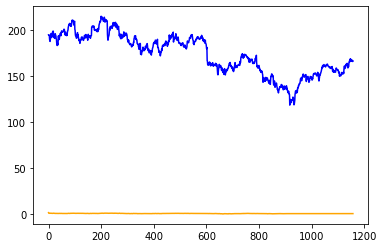

In [11]:
plt.plot(truth, 'b')
plt.plot(predict, 'orange')
plt.savefig(os.path.join(root, "results", date_time, "origin.png"))
plt.show()

In [12]:
predict = np.reshape(predict, (1, -1))
predict = np.squeeze(normalize(np.array(predict)))
truth = np.reshape(truth, (1, -1))
truth = np.squeeze(normalize(np.array(truth)))

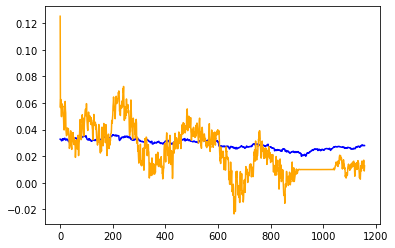

In [13]:
plt.plot(truth, 'b')
plt.plot(predict, 'orange')
plt.savefig(os.path.join(root, "results", date_time, "normalize.png"))
plt.show()